# **Deep Learning Neural Networks** <br/>
# **Alien vs. Predator** <br/>
**Postgraduate Program Enterprise Data Science & Analytics (A.Y. 2022/2023)**<br/>
**NOVA IMS**<br/>
Soraia Alves (m20201840@novaims.unl.pt)<br/>
Ricardo Almeida (m20201335@novaims.unl.pt)<br/>
Teresa Barroso (t2003041@novaims.unl.pt)<br/>
Nuno Almeida (m20211056@novaims.unl.pt)<br/>
João Rodrigues (m20180550@novaims.unl.pt)

# 0. Import the required libraries.

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import callbacks, Sequential, layers, initializers, regularizers, optimizers, metrics 

import os
import time
import random 
import zipfile
from shutil import copyfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

from sklearn.metrics import confusion_matrix

# 1. Load the data.<br>
To load the images, the `keras.utils.image_dataset_from_directory()` function will be used. By definition, this function reads images from a folder with as many subfolders as the number of classes. Each subfolder must contain images that belong to the same class. Typically, training and test images are organized into separate folders following the aforementioned structure; therefore, the function is called separately, for each partition. Consider the following example:
```
main_folder\\
└───training_data\\
│                └───class_a\\
│                           │...a_image_1.jpg
│                           │...a_image_2.jpg
│                └───class_b
│                           │...b_image_1.jpg
│                           │...b_image_2.jpg
└───testing_data\\
│                └───class_a\\
│                           │...a_image_1000.jpg
│                           │...a_image_1001.jpg
│                └───class_b
│                           │...b_image_1000.jpg
│                           │...b_image_1001.jpg

```
The `keras.utils.image_dataset_from_directory()` function takes the following [arguments](https://keras.io/api/data_loading/image/):
-  `directory`: path towards data partition. The latter should contain subdirectories, each containing images for a class;
-  `labels`: list or tuple of class labels sorted according to the alphanumeric order of the image file paths. Alternatively, class labels are generated from the directory structure
-  `color_mode`: images color mode (set to ``"rgb"`` by default). Use ``"grayscale"`` to convert to grayscale
-  `batch_size`:  number of images loaded in computer's memory at each call
-  `image_size`: images' size once they are read from the disk ``(img_height, img_width)``
-  `shuffle`:  randomization of the instances order. It is fundamental to ensure that each minibatch is representative of the whole set of classes (or as many classes as possible)
-  `interpolation`: interpolation method used when resizing images
-  `validation_split`: specifies the proportion of images to reserve for the validation (its complement will be used for the training set). When specified, the arguments `subset` specifies whether the set of `"training"` and/or `"validation"` images will be loaded.
 -  `crop_to_aspect_ratio`:  when the original aspect ratio differs from the target aspect ratio, the output image will be cropped so as to return the largest possible window in the image.

Connects to the Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip file to the virtual machine's session.

In [ ]:
# Set connection string 
path = "/content/drive/MyDrive/DLNN/Final_project/"
# Measure time
t0 = time.time()
# Transfer zip dataset to the current virtual machine
copyfile(path + "alien_predator.zip", 'alien_predator.zip')
# Extract files
zip_file = zipfile.ZipFile('alien_predator.zip')
zip_file.extractall()
zip_file.close()
print("File transfer completed in %0.3f seconds" % (time.time() - t0))
path = "/content/"
# Define the sub-folders
main_folder, training_folder, testing_folder = "data/data/", "train/", "test/"

File transfer completed in 0.979 seconds


Take a look at 4 data instances (images) from training and test folders, for each class (alien and predator).

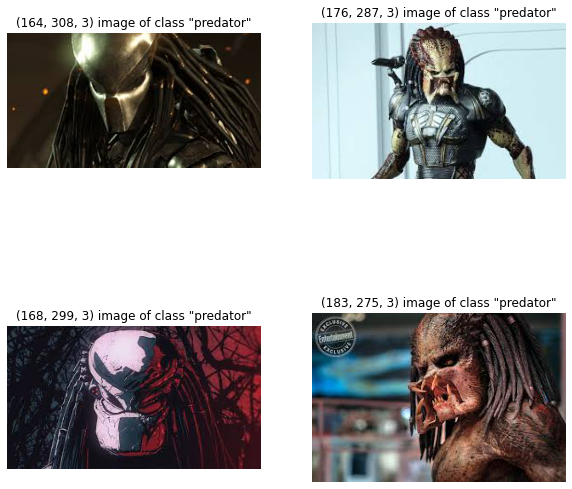

In [ ]:
def show_sample_images(folder_directory, class_):
    # Build a connection string
    full_path = folder_directory + class_ + "/"
    # Get a set of random images
    images = random.sample(os.listdir(full_path), 4)
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        img = mpimg.imread(full_path + img)
        ax = plt.subplot(2, 2,  i + 1)
        plt.imshow(img)
        plt.title("{} image of class \"{}\"".format(img.shape, class_))
        plt.axis("off")

show_sample_images(path + main_folder + training_folder, "predator")

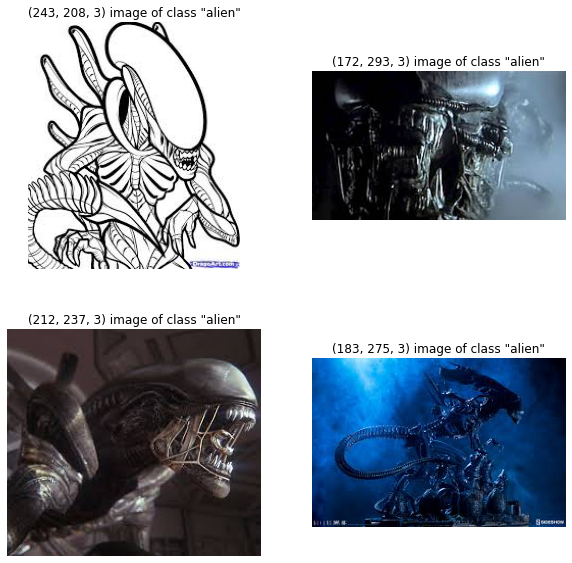

In [ ]:
show_sample_images(path + main_folder + training_folder, "alien")

Uses the function ``image_data_format()`` to verify the default image data format convention. We can see that images' shape is compatible with default convention.

PS - ``"channels_last"`` means (H, W, C), whereas ``"channels_first"`` means (C, H, W).

In [ ]:
tf.keras.backend.image_data_format()

'channels_last'

Inspect classes' balance.

In [ ]:
for split in [training_folder, testing_folder]:
    for c in ["alien", "predator"]:
        n_train_c = len(os.listdir(path + main_folder + split + f"{c}"))
        print(f"Nº of instances of class {c} in the {split}: {n_train_c}")

Nº of instances of class alien in the train/: 347
Nº of instances of class predator in the train/: 347
Nº of instances of class alien in the test/: 100
Nº of instances of class predator in the test/: 100


Defines a list of parameters for the ``image_dataset_from_directory``.

In [ ]:
# Import Packages
from PIL import Image
import imagesize

In [ ]:
def show_image_size(folder_directory, class_):
    # Build a connection string
    full_path = folder_directory + class_ + "/"
    images = os.listdir(full_path)
    altura = []
    largura = []
    aspect_ratio = []
    for i, img in enumerate(images):
        img = imagesize.get(full_path + img)
        altura.append(img[0])
        largura.append(img[1])
        aspect_ratio.append(img[0]/img[1])
    avg_largura = round(sum(altura)/len(altura))
    avg_altura = round(sum(largura)/len(largura))
    avg_aspect_ratio = round(sum(aspect_ratio)/len(aspect_ratio),2)
    print(f'The average width of {full_path} is {avg_largura}')
    print(f'The average heigth of {full_path} is {avg_altura}')
    print(f'The average aspect_ratio of {full_path} is {avg_aspect_ratio}')

In [ ]:
show_image_size(path + main_folder + training_folder, "predator")
show_image_size(path + main_folder + training_folder, "alien")
show_image_size(path + main_folder + testing_folder, "predator")
show_image_size(path + main_folder + testing_folder, "alien")

The average width of /content/data/data/train/predator/ is 247
The average heigth of /content/data/data/train/predator/ is 212
The average aspect_ratio of /content/data/data/train/predator/ is 1.27
The average width of /content/data/data/train/alien/ is 252
The average heigth of /content/data/data/train/alien/ is 207
The average aspect_ratio of /content/data/data/train/alien/ is 1.31
The average width of /content/data/data/test/predator/ is 250
The average heigth of /content/data/data/test/predator/ is 207
The average aspect_ratio of /content/data/data/test/predator/ is 1.31
The average width of /content/data/data/test/alien/ is 255
The average heigth of /content/data/data/test/alien/ is 203
The average aspect_ratio of /content/data/data/test/alien/ is 1.33


In [ ]:
image_size=(128, 128)
crop_to_aspect_ratio = True
color_mode='rgb'
batch_size=64
label_mode="binary"
validation_split=0.3
shuffle=True
seed=0

*Why these parameters?*


```python
image_size=(256,256)
```
* This argument takes the number of pixels (height, width) that *tf.keras.utils.image_dataset_from_directory* will use to resize a batch the batch of images to be processed, since all images must have the same size. The default value is 256 for both, hence why 256 was chosen. If need be due to computing power needs, it can be later adjusted.


```python
crop_to_aspect_ratio = True
```
* Certifies that the aspect ratio for all images is preserved, independently of their original aspect ratio, which is useful for guaranteeing that all images are standardized.

```python
color_mode='rgb'
```

* Guarantees all images will be converted to having 3 channels (red, green, blue). 'rgb' is the default value for the parameter, the alternatives being grayscale (which is not useful, since there are multiple colored images) and rgba, a 4 channel format that includes an alpha-value (an opacity measure), which is not useful for our purpose. 

```python
batch_size=32
```
* 'batch_size' indicates the size of the data batches. In this case, the default value is 32, which we chose to keep and later adjust if need be, due to computing needs.

```python
label_mode="binary"
```
* This parameter defines the encoding the labels for each image, encoded as float32 scalars with value 0 or 1. Since we only have two possible results (Alien - 0 or Predator - 1) this is the most appropriate 'label_mode', the alternatives being 'int' (labels are encoded as integers) and 'categorical' (labels are encoded as a categorical vector).

```python
validation_split=0.3
```
* Defines the fraction of data reserved for data validation. In this case, we chose to proceed with 30% of the training set, even though 20% is another common choice. We chose 30%, because we have a small dataset and believe the training set should be as close in size as possible to the validation dataset. With this option we have 208 images in the validation set, and 200 in the training set.

```python
shuffle=True
```
* 'shuffle' defines wheter we want to shuffle our data or not. Since our data is balanced and we want the algorithm not to always look at the data in the same order, we chose True.

```python
seed=0
```
* Sets a random seed used for shuffling and transformations. It is an integer used to initialize a pseurandom number generator. In this case, we chose to proceed with 0.



Loads the training data using the ``image_dataset_from_directory`` function. Performs an automatic split in training and validation data via ``validation_split``.

In [ ]:
# Generate an object of type tf.data.Dataset for training data
ds_train = image_dataset_from_directory(path + main_folder + training_folder, 
                                        image_size=image_size,
                                        crop_to_aspect_ratio=crop_to_aspect_ratio,
                                        color_mode=color_mode,
                                        batch_size=batch_size,
                                        label_mode=label_mode,
                                        subset='training',
                                        validation_split=validation_split, 
                                        shuffle=shuffle,
                                        seed=seed)
# Generate an object of type tf.data.Dataset for validation data
ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                      image_size=image_size,
                                      crop_to_aspect_ratio=crop_to_aspect_ratio,
                                      color_mode=color_mode,
                                      batch_size=batch_size,
                                      label_mode=label_mode,
                                      subset='validation',
                                      validation_split=validation_split, 
                                      shuffle=shuffle,
                                      seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 694 files belonging to 2 classes.
Using 486 files for training.
Found 694 files belonging to 2 classes.
Using 208 files for validation.

Object's type:	 <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['alien', 'predator']


One can simply iterate over the dataset's items. For this, one can (i) either obtain an [iterator object](https://docs.python.org/3/library/functions.html#iter) from an instance of ``tf.data.Dataset``, (ii) or iterate it in a for loop.

In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(64, 128, 128, 3) (64, 1)

Sample of y_train: tf.Tensor(
[[0.]
 [1.]
 [0.]
 [1.]
 [1.]], shape=(5, 1), dtype=float32)
Sample average of y_train: tf.Tensor(0.5, shape=(), dtype=float32)


Plot images loaded with ``iter_train`` object.

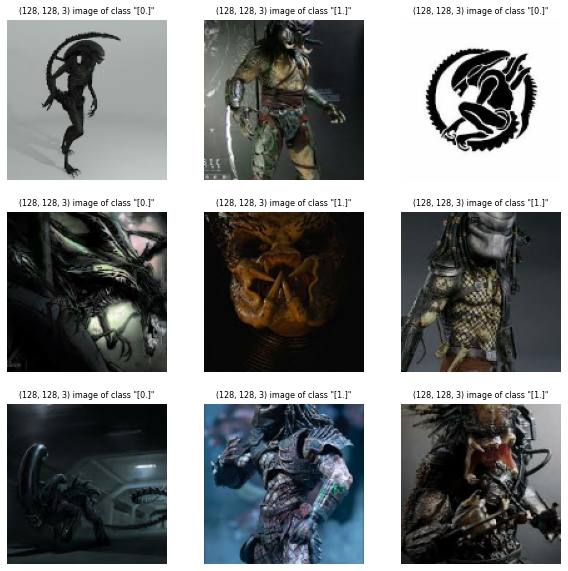

In [ ]:
def show_sample_batch(ds, grid_size=(3, 3)):
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")

show_sample_batch(ds_train)

Loads the testing data using the ``image_dataset_from_directory`` function.

In [ ]:
ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 200 files belonging to 2 classes.


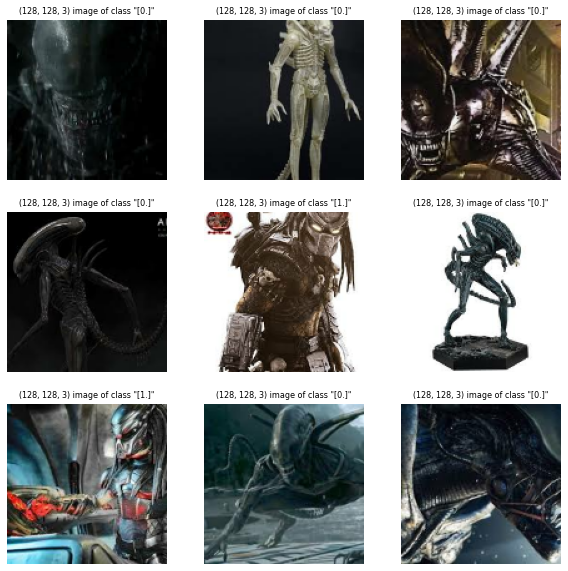

In [ ]:
show_sample_batch(ds_test)

# 2. Data preprocessing.<br>
Keras preprocessing layers essentially allow you to resize your images to a consistent shape and to rescale pixel values. There are three fundamental layers:
- [``tf.keras.layers.Resizing``](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/resizing/): resizes a batch of images using some interpolation method
- [`tf.keras.layers.Rescaling`](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/): rescales the values of a batch of images to a given range (aka min-max scaler). "To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255" [(citation reference)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling#for_instance).
- [`tf.keras.layers.CenterCrop`](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/center_crop/): returns a center crop of a batch of images<br>
The pixel values in tensors representing images must be scaled before flowing them into a DL model during the training or evaluation of the model.
The cell below creates a preprocessing pipeline using a ``Sequential`` container. The pipeline performs image scaling down to [0, 1]. Given the fact image resizing is already performed by the ``image_dataset_from_directory()`` function, no resizing and cropping is required.

In [ ]:
preprocessing = layers.Rescaling(1./255)

Alternatively, one can normalize the input samples to zero mean and unit variance by adding ``keras.layers.BatchNormalization()`` (BN). Adding BN **as the first layer of your classifier** allows to normalize the inputs using the mean and the standard deviation of the current batch. The mean and standard-deviation are calculated per-dimension over the batches and $\gamma$ and $\beta$ are learnable parameter vectors of size $C$ (number of channels). By default, values of $\gamma$ and $\beta$ are set to 1 and 0, respectively. Formally, at each input channel:

$$y = \frac{x - E[x]}{\sqrt{Var[x]+\epsilon]}}*\gamma+\beta$$

Notice that, **when defining the input layer** using ``keras.layers.Input`` class, one needs to provide the keyword argument ``input_shape`` as a tuple of integers. By default, it does not include the sample axis (at index 0). Therefore, for RGB input pictures of size 256x256 coming in batches, one just needs to specify ``input_shape=(256, 256, 3)``. Consult the [official documentation](https://keras.io/api/layers/core_layers/input/) for more details.

In [ ]:
input_shape = tuple(batch_x_train.shape)
preprocessing = Sequential([# The input layer
                            layers.Input(input_shape[1:]),
                            # The batch normalization layer 
                            layers.BatchNormalization(),                    
                            # The remaining neural architecture 
                            # (...)
                   ])

# 3. Data augmentation.<br>
Data augmentation is a technique that increases the level of diversity in the training data by using randomized transformations. This is particularly revelant when the dataset is small and underrepresentative of reality. By using data augmentation, the model gets exposed to the different variations in the training data, and it is expected to generalize better.

These [layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/) implement data augmentation on a batch of images **during the training**: 
-  [`tf.keras.layers.RandomCrop`](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_crop/#randomcrop-class): crops images in a batch down to user specified ``height`` and ``width`` arguments;
-  [`tf.keras.layers.RandomFlip`](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_flip/#randomflip-class): flips images horizontally or/and vertically;
-  [`tf.keras.layers.RandomTranslation`](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_translation/#randomtranslation-class): randomly translates images;
-  [`tf.keras.layers.RandomRotation`](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_rotation/#randomrotation-class): randomly rotates images;
-  [`tf.keras.layers.RandomZoom`](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_zoom/#randomzoom-class): randomly zooms images;
-  [`tf.keras.layers.RandomHeight`](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_height/#randomheight-class): randomly varies image heights;
-  [`tf.keras.layers.RandomWidth`](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_width/#randomwidth-class):
randomly varies image weights;
-  [`tf.keras.layers.RandomContrast`](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_contrast/#randomcontrast-class): randomly adjust contrast.

In [ ]:
augmentation = Sequential([layers.RandomFlip(seed=seed), 
                           layers.RandomRotation(0.1, seed=seed), 
                           layers.RandomZoom(0.1, seed=seed),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                           layers.RandomContrast(0.1, seed=seed)],
                           name="augmentation")

Visualize a single image that passess through the data augmentation pipeline. Note that data augmentation layers only perform operations during the training phase. Therefore, to test a pipeline use ``training=True``.

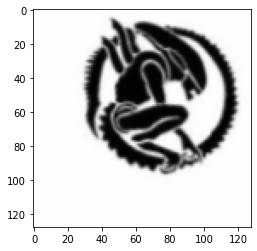

In [ ]:
plt.imshow(tf.cast(augmentation(batch_x_train[0], training=True), tf.int32))

The cell below defines a utility function to visualize how the data augmentation applies on a set of images.

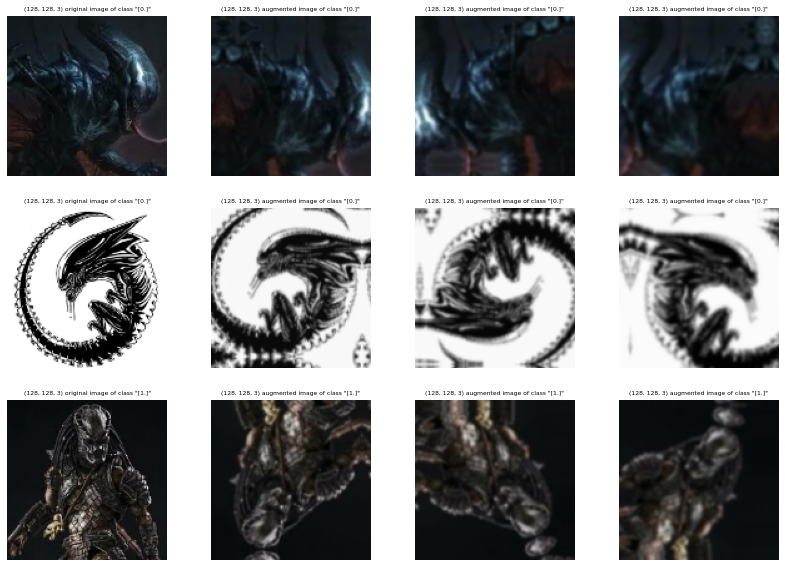

In [ ]:
def show_sample_batch(ds, augmentation, grid_size=(3, 4), figsize=(14, 10)):
    n_images = grid_size[0]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(14, 10))
    count = 0
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        img_ = tf.cast(img, tf.int32)
        for j in range(grid_size[1]):
            # Prepare the image
            if j>0:
                img_ = tf.cast(augmentation(img_, training=True), tf.int32)
            ax = plt.subplot(grid_size[0], grid_size[1],  count + 1)        
            plt.imshow(img_)
            plt.title("{} {} image of class \"{}\"".format(
                img.shape, "original" if j==0 else "augmented", y), size=6)
            plt.axis("off")
            count+=1

show_sample_batch(ds_train, augmentation=augmentation)

# 4. Convolutional Neural Networks (CNNs).

## 4.1. CNN-V1.
Simple CNN architecture (2 blocks with 3 layers: convolutional, activation and pooling) without data augmentation and input processing.

In [ ]:
input_shape = batch_x_train.shape
# Architecture v1
cnn1 = Sequential([# Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn1.build(input_shape)
# Check network
cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (64, 126, 126, 32)        896       
                                                                 
 activation (Activation)     (64, 126, 126, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (64, 63, 63, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 61, 61, 64)          18496     
                                                                 
 activation_1 (Activation)   (64, 61, 61, 64)          0         
                                                                 
 global_max_pooling2d (Globa  (64, 64)                 0         
 lMaxPooling2D)                                       

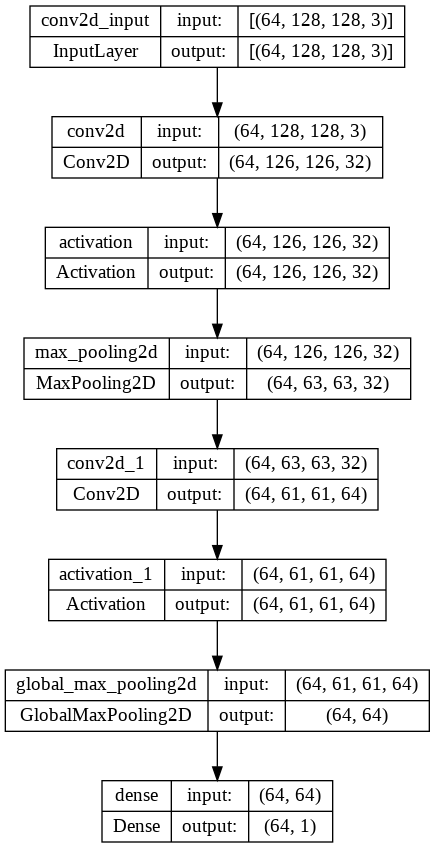

In [ ]:
tf.keras.utils.plot_model(cnn1, show_shapes=True)

Compiles the model for training.

In [ ]:
learning_rate = 0.01
cnn1.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])

Fits the model on ``ds_train``. Uses ``ds_val`` for validation.

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn1_checkpoint",
    monitor="val_accuracy",
    save_freq="epoch", # default value is 'epoch'
    save_best_only=True
)

In [ ]:
# Model training (v1)
epochs = 100
history1 = cnn1.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[early_stopping, model_checkpoint])
cnn1.save("cnn_model.h1")

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 68.6714 - accuracy: 0.5432 - recall: 0.3800 - precision: 0.5864 - AUROC: 0.5501

8/8 [==============================] - 17s 2s/step - loss: 68.6714 - accuracy: 0.5432 - recall: 0.3800 - precision: 0.5864 - AUROC: 0.5501 - val_loss: 3.2945 - val_accuracy: 0.4712 - val_recall: 1.0000 - val_precision: 0.4686 - val_AUROC: 0.5371
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 1.4664 - accuracy: 0.5432 - recall: 0.9720 - precision: 0.5306 - AUROC: 0.6047

8/8 [==============================] - 13s 2s/step - loss: 1.4664 - accuracy: 0.5432 - recall: 0.9720 - precision: 0.5306 - AUROC: 0.6047 - val_loss: 0.6770 - val_accuracy: 0.5433 - val_recall: 0.6082 - val_precision: 0.5086 - val_AUROC: 0.5774
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.6466 - accuracy: 0.6214 - recall: 0.4360 - precision: 0.7171 - AUROC: 0.6161

8/8 [==============================] - 12s 2s/step - loss: 0.6466 - accuracy: 0.6214 - recall: 0.4360 - precision: 0.7171 - AUROC: 0.6161 - val_loss: 0.6479 - val_accuracy: 0.6298 - val_recall: 0.3093 - val_precision: 0.7500 - val_AUROC: 0.6389
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.7058 - recall: 0.6120 - precision: 0.7688 - AUROC: 0.7493

8/8 [==============================] - 12s 2s/step - loss: 0.5902 - accuracy: 0.7058 - recall: 0.6120 - precision: 0.7688 - AUROC: 0.7493 - val_loss: 0.6557 - val_accuracy: 0.6538 - val_recall: 0.3711 - val_precision: 0.7660 - val_AUROC: 0.6402
Epoch 5/100
8/8 [==============================] - ETA: 0s - loss: 0.5993 - accuracy: 0.6770 - recall: 0.4320 - precision: 0.8780 - AUROC: 0.7082

8/8 [==============================] - 13s 2s/step - loss: 0.5993 - accuracy: 0.6770 - recall: 0.4320 - precision: 0.8780 - AUROC: 0.7082 - val_loss: 0.6574 - val_accuracy: 0.6635 - val_recall: 0.3918 - val_precision: 0.7755 - val_AUROC: 0.6271
Epoch 6/100
8/8 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.7490 - recall: 0.6680 - precision: 0.8107 - AUROC: 0.7944

8/8 [==============================] - 15s 2s/step - loss: 0.5618 - accuracy: 0.7490 - recall: 0.6680 - precision: 0.8107 - AUROC: 0.7944 - val_loss: 0.6544 - val_accuracy: 0.7019 - val_recall: 0.5464 - val_precision: 0.7465 - val_AUROC: 0.7048
Epoch 7/100
8/8 [==============================] - ETA: 0s - loss: 0.5334 - accuracy: 0.7737 - recall: 0.7480 - precision: 0.7991 - AUROC: 0.8134

8/8 [==============================] - 13s 2s/step - loss: 0.5334 - accuracy: 0.7737 - recall: 0.7480 - precision: 0.7991 - AUROC: 0.8134 - val_loss: 0.6686 - val_accuracy: 0.7163 - val_recall: 0.7526 - val_precision: 0.6759 - val_AUROC: 0.7764
Epoch 8/100
8/8 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.7778 - recall: 0.6840 - precision: 0.8550 - AUROC: 0.8069

8/8 [==============================] - 15s 2s/step - loss: 0.5389 - accuracy: 0.7778 - recall: 0.6840 - precision: 0.8550 - AUROC: 0.8069 - val_loss: 0.6526 - val_accuracy: 0.7308 - val_recall: 0.5876 - val_precision: 0.7808 - val_AUROC: 0.7581
Epoch 9/100
8/8 [==============================] - 12s 1s/step - loss: 0.5173 - accuracy: 0.7613 - recall: 0.6040 - precision: 0.8988 - AUROC: 0.8059 - val_loss: 0.6719 - val_accuracy: 0.7260 - val_recall: 0.6082 - val_precision: 0.7564 - val_AUROC: 0.7680
Epoch 10/100
8/8 [==============================] - 11s 1s/step - loss: 0.5040 - accuracy: 0.7675 - recall: 0.6840 - precision: 0.8341 - AUROC: 0.8358 - val_loss: 0.6000 - val_accuracy: 0.7212 - val_recall: 0.5258 - val_precision: 0.8095 - val_AUROC: 0.7570
Epoch 11/100
8/8 [==============================] - 11s 1s/step - loss: 0.4857 - accuracy: 0.7757 - recall: 0.7160 - precision: 0.8249 - AUROC: 0.8426 - val_loss: 0.6233 - val_accuracy: 0.7067 - val_recall: 0.5052 - val_precision: 0.7903 - 

In [ ]:
score, acc, rec, prec, auc = cnn1.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn1.evaluate(ds_val, verbose=0)

print("Val loss score: %0.3f" % (score))
print("Val accuracy: %0.3f" % (acc))
print("Val recall: %0.3f" % (rec))
print("Val precision: %0.3f" % (prec))
print("Val AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn1.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.502
Training accuracy: 0.774
Training recall: 0.676
Training precision: 0.854
Training AUROC: 0.818
Val loss score: 0.653
Val accuracy: 0.731
Val recall: 0.588
Val precision: 0.781
Val AUROC: 0.758
Test loss score: 0.699
Test accuracy: 0.715
Test recall: 0.580
Test precision: 0.795
Test AUROC: 0.733


Plots the learning curves.

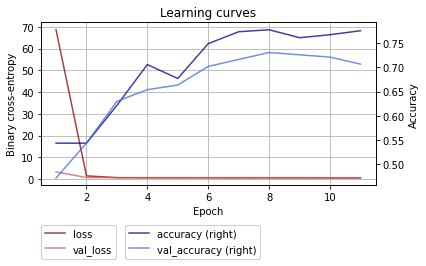

In [ ]:
# Create DataFrame object
df_hist1 = pd.DataFrame.from_dict(history1.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"] 
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

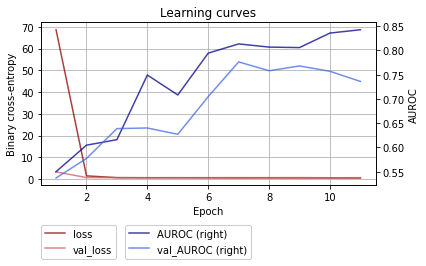

In [ ]:
# Create DataFrame object
df_hist1 = pd.DataFrame.from_dict(history1.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
len(cnn1.layers)

7

## 4.2. CNN-V2.
Consider the architecture CNN-V1 with input scaling. In this case, inputs are scaled by placing the ``Rescaling()`` layer to the head of the ``Sequential()`` model.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v2
cnn2 = Sequential([# The rescaling layer 
                   layers.Rescaling(1./255),                           
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn2.build(input_shape)
# Check network
cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (64, 128, 128, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (64, 126, 126, 32)        896       
                                                                 
 activation_2 (Activation)   (64, 126, 126, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 63, 63, 32)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (64, 61, 61, 64)          18496     
                                                                 
 activation_3 (Activation)   (64, 61, 61, 64)          0         
                                                      

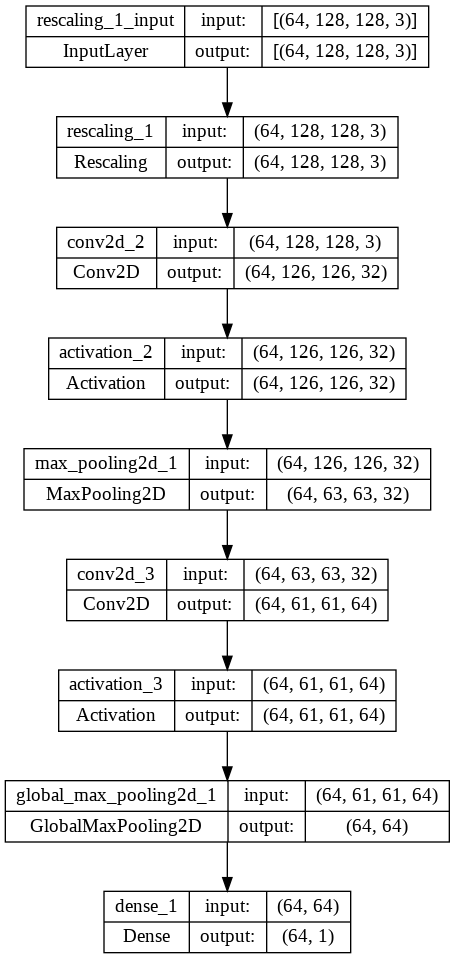

In [ ]:
tf.keras.utils.plot_model(cnn2, show_shapes=True)

Compiles and fits the model.

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn2_checkpoint",
    monitor="val_accuracy",
    save_freq="epoch", # default value is 'epoch'
    save_best_only=True
)

In [ ]:
# Compile the model
cnn2.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# Model training 
epochs = 100
history2 = cnn2.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[early_stopping, model_checkpoint])
cnn2.save("cnn_model.h2")

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.7557 - accuracy: 0.5103 - recall: 0.4680 - precision: 0.5270 - AUROC: 0.5004

8/8 [==============================] - 15s 2s/step - loss: 0.7557 - accuracy: 0.5103 - recall: 0.4680 - precision: 0.5270 - AUROC: 0.5004 - val_loss: 0.6906 - val_accuracy: 0.5337 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_AUROC: 0.5744
Epoch 2/100
8/8 [==============================] - 12s 1s/step - loss: 0.6843 - accuracy: 0.5514 - recall: 0.6560 - precision: 0.5541 - AUROC: 0.5804 - val_loss: 0.6836 - val_accuracy: 0.4712 - val_recall: 1.0000 - val_precision: 0.4686 - val_AUROC: 0.7560
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 0.5844 - recall: 0.9280 - precision: 0.5577 - AUROC: 0.7893

8/8 [==============================] - 13s 2s/step - loss: 0.6356 - accuracy: 0.5844 - recall: 0.9280 - precision: 0.5577 - AUROC: 0.7893 - val_loss: 0.6159 - val_accuracy: 0.6731 - val_recall: 0.8144 - val_precision: 0.6124 - val_AUROC: 0.7943
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.5595 - accuracy: 0.7510 - recall: 0.8280 - precision: 0.7263 - AUROC: 0.8318

8/8 [==============================] - 14s 2s/step - loss: 0.5595 - accuracy: 0.7510 - recall: 0.8280 - precision: 0.7263 - AUROC: 0.8318 - val_loss: 0.5922 - val_accuracy: 0.7356 - val_recall: 0.7216 - val_precision: 0.7143 - val_AUROC: 0.7873
Epoch 5/100
8/8 [==============================] - 12s 1s/step - loss: 0.5280 - accuracy: 0.7593 - recall: 0.7320 - precision: 0.7854 - AUROC: 0.8226 - val_loss: 0.5999 - val_accuracy: 0.7356 - val_recall: 0.7629 - val_precision: 0.6981 - val_AUROC: 0.7942
Epoch 6/100
8/8 [==============================] - ETA: 0s - loss: 0.5061 - accuracy: 0.7757 - recall: 0.7280 - precision: 0.8161 - AUROC: 0.8274

8/8 [==============================] - 13s 2s/step - loss: 0.5061 - accuracy: 0.7757 - recall: 0.7280 - precision: 0.8161 - AUROC: 0.8274 - val_loss: 0.5583 - val_accuracy: 0.7404 - val_recall: 0.5979 - val_precision: 0.7945 - val_AUROC: 0.7841
Epoch 7/100
8/8 [==============================] - 12s 1s/step - loss: 0.5015 - accuracy: 0.7798 - recall: 0.7160 - precision: 0.8326 - AUROC: 0.8382 - val_loss: 0.5604 - val_accuracy: 0.7212 - val_recall: 0.5361 - val_precision: 0.8000 - val_AUROC: 0.7974
Epoch 8/100
8/8 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.7860 - recall: 0.7280 - precision: 0.8349 - AUROC: 0.8340

8/8 [==============================] - 15s 2s/step - loss: 0.5025 - accuracy: 0.7860 - recall: 0.7280 - precision: 0.8349 - AUROC: 0.8340 - val_loss: 0.5589 - val_accuracy: 0.7452 - val_recall: 0.5876 - val_precision: 0.8143 - val_AUROC: 0.7790
Epoch 9/100
8/8 [==============================] - 12s 1s/step - loss: 0.5250 - accuracy: 0.7366 - recall: 0.5480 - precision: 0.9013 - AUROC: 0.8301 - val_loss: 0.5921 - val_accuracy: 0.7404 - val_recall: 0.7216 - val_precision: 0.7216 - val_AUROC: 0.7923
Epoch 10/100
8/8 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.7716 - recall: 0.7600 - precision: 0.7884 - AUROC: 0.8519

8/8 [==============================] - 13s 2s/step - loss: 0.4974 - accuracy: 0.7716 - recall: 0.7600 - precision: 0.7884 - AUROC: 0.8519 - val_loss: 0.5547 - val_accuracy: 0.7548 - val_recall: 0.6289 - val_precision: 0.8026 - val_AUROC: 0.7911
Epoch 11/100
8/8 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.7737 - recall: 0.6440 - precision: 0.8846 - AUROC: 0.8530

8/8 [==============================] - 13s 2s/step - loss: 0.4924 - accuracy: 0.7737 - recall: 0.6440 - precision: 0.8846 - AUROC: 0.8530 - val_loss: 0.5680 - val_accuracy: 0.7596 - val_recall: 0.7010 - val_precision: 0.7640 - val_AUROC: 0.7902
Epoch 12/100
8/8 [==============================] - 12s 1s/step - loss: 0.4881 - accuracy: 0.7922 - recall: 0.7720 - precision: 0.8143 - AUROC: 0.8556 - val_loss: 0.5579 - val_accuracy: 0.7596 - val_recall: 0.6495 - val_precision: 0.7975 - val_AUROC: 0.7881
Epoch 13/100
8/8 [==============================] - ETA: 0s - loss: 0.4891 - accuracy: 0.7716 - recall: 0.6400 - precision: 0.8840 - AUROC: 0.8511

8/8 [==============================] - 15s 2s/step - loss: 0.4891 - accuracy: 0.7716 - recall: 0.6400 - precision: 0.8840 - AUROC: 0.8511 - val_loss: 0.5660 - val_accuracy: 0.7644 - val_recall: 0.7010 - val_precision: 0.7727 - val_AUROC: 0.7929
Epoch 14/100
8/8 [==============================] - 12s 1s/step - loss: 0.4908 - accuracy: 0.7819 - recall: 0.7560 - precision: 0.8077 - AUROC: 0.8426 - val_loss: 0.5599 - val_accuracy: 0.7308 - val_recall: 0.5361 - val_precision: 0.8254 - val_AUROC: 0.7879
Epoch 15/100
8/8 [==============================] - 12s 1s/step - loss: 0.4919 - accuracy: 0.7757 - recall: 0.6600 - precision: 0.8730 - AUROC: 0.8394 - val_loss: 0.5832 - val_accuracy: 0.7500 - val_recall: 0.7216 - val_precision: 0.7368 - val_AUROC: 0.7892
Epoch 16/100
8/8 [==============================] - 12s 1s/step - loss: 0.4842 - accuracy: 0.7778 - recall: 0.7160 - precision: 0.8287 - AUROC: 0.8498 - val_loss: 0.5549 - val_accuracy: 0.7596 - val_recall: 0.6495 - val_precision: 0.7975 -

In [ ]:
score, acc, rec, prec, auc = cnn2.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn2.evaluate(ds_val, verbose=0)

print("Val loss score: %0.3f" % (score))
print("Val accuracy: %0.3f" % (acc))
print("Val recall: %0.3f" % (rec))
print("Val precision: %0.3f" % (prec))
print("Val AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn2.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.474
Training accuracy: 0.780
Training recall: 0.716
Training precision: 0.833
Training AUROC: 0.857
Val loss score: 0.566
Val accuracy: 0.764
Val recall: 0.701
Val precision: 0.773
Val AUROC: 0.793
Test loss score: 0.596
Test accuracy: 0.720
Test recall: 0.640
Test precision: 0.762
Test AUROC: 0.770


Plots the learning curves.

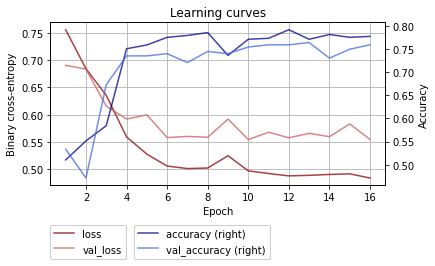

In [ ]:
# Create DataFrame object
df_hist2 = pd.DataFrame.from_dict(history2.history)
df_hist2["Epoch"] = np.arange(1, len(df_hist2) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist2.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

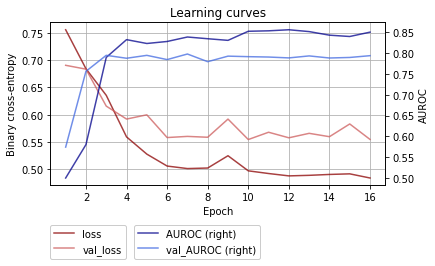

In [ ]:
# Create DataFrame object
df_hist2 = pd.DataFrame.from_dict(history2.history)
df_hist2["Epoch"] = np.arange(1, len(df_hist2) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]
ax = df_hist2.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
len(cnn2.layers)

8

## 4.3. CNN-V3.
Consider the architecture CNN-V1 with input scaling. In this case, inputs are scaled by placing the ``BatchNormalization()`` layer to the head of the ``Sequential()`` model.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v3
cnn3 = Sequential([# The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn3.build(input_shape)
# Check network
cnn3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (64, 126, 126, 32)        896       
                                                                 
 activation_4 (Activation)   (64, 126, 126, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (64, 63, 63, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (64, 61, 61, 64)          18496     
                                                                 
 activation_5 (Activation)   (64, 61, 61, 64)         

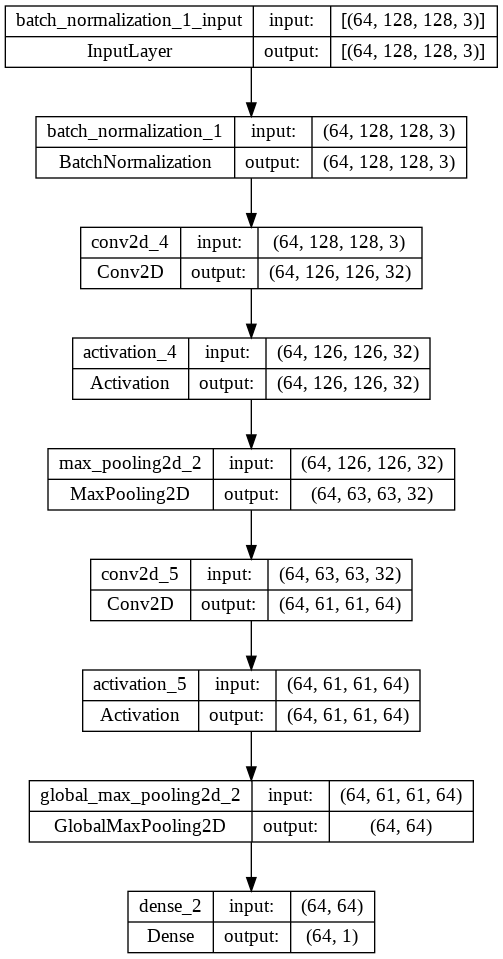

In [ ]:
tf.keras.utils.plot_model(cnn3, show_shapes=True)

Compiles and fits the model.

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn3_checkpoint",
    monitor="val_accuracy",
    save_freq="epoch", # default value is 'epoch'
    save_best_only=True
)

In [ ]:
# Compile the model
cnn3.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# Model training 
epochs = 100
history3 = cnn3.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[early_stopping, model_checkpoint])
cnn3.save("cnn_model.h3")

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.9617 - accuracy: 0.4650 - recall: 0.3640 - precision: 0.4740 - AUROC: 0.4825

8/8 [==============================] - 18s 2s/step - loss: 0.9617 - accuracy: 0.4650 - recall: 0.3640 - precision: 0.4740 - AUROC: 0.4825 - val_loss: 0.9114 - val_accuracy: 0.5337 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_AUROC: 0.6024
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.5432 - recall: 0.5720 - precision: 0.5543 - AUROC: 0.5746

8/8 [==============================] - 15s 2s/step - loss: 0.6838 - accuracy: 0.5432 - recall: 0.5720 - precision: 0.5543 - AUROC: 0.5746 - val_loss: 1.0860 - val_accuracy: 0.5385 - val_recall: 0.0103 - val_precision: 1.0000 - val_AUROC: 0.5547
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.6129 - accuracy: 0.6626 - recall: 0.5840 - precision: 0.7087 - AUROC: 0.7355

8/8 [==============================] - 17s 2s/step - loss: 0.6129 - accuracy: 0.6626 - recall: 0.5840 - precision: 0.7087 - AUROC: 0.7355 - val_loss: 0.5765 - val_accuracy: 0.7163 - val_recall: 0.7113 - val_precision: 0.6900 - val_AUROC: 0.7751
Epoch 4/100
8/8 [==============================] - 14s 2s/step - loss: 0.5501 - accuracy: 0.6872 - recall: 0.7760 - precision: 0.6690 - AUROC: 0.7975 - val_loss: 0.7635 - val_accuracy: 0.6875 - val_recall: 0.4227 - val_precision: 0.8200 - val_AUROC: 0.7489
Epoch 5/100
8/8 [==============================] - 14s 2s/step - loss: 0.5315 - accuracy: 0.7551 - recall: 0.7360 - precision: 0.7764 - AUROC: 0.8055 - val_loss: 0.8041 - val_accuracy: 0.6875 - val_recall: 0.4021 - val_precision: 0.8478 - val_AUROC: 0.7412
Epoch 6/100
8/8 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.7407 - recall: 0.6280 - precision: 0.8263 - AUROC: 0.7991

8/8 [==============================] - 15s 2s/step - loss: 0.5295 - accuracy: 0.7407 - recall: 0.6280 - precision: 0.8263 - AUROC: 0.7991 - val_loss: 0.5664 - val_accuracy: 0.7308 - val_recall: 0.6495 - val_precision: 0.7412 - val_AUROC: 0.7786
Epoch 7/100
8/8 [==============================] - 14s 2s/step - loss: 0.5131 - accuracy: 0.7675 - recall: 0.7200 - precision: 0.8072 - AUROC: 0.8305 - val_loss: 0.5701 - val_accuracy: 0.7308 - val_recall: 0.5670 - val_precision: 0.7971 - val_AUROC: 0.7699
Epoch 8/100
8/8 [==============================] - ETA: 0s - loss: 0.4872 - accuracy: 0.7819 - recall: 0.7120 - precision: 0.8396 - AUROC: 0.8437

8/8 [==============================] - 17s 2s/step - loss: 0.4872 - accuracy: 0.7819 - recall: 0.7120 - precision: 0.8396 - AUROC: 0.8437 - val_loss: 0.6030 - val_accuracy: 0.7692 - val_recall: 0.7113 - val_precision: 0.7753 - val_AUROC: 0.7875
Epoch 9/100
8/8 [==============================] - 14s 2s/step - loss: 0.4714 - accuracy: 0.7984 - recall: 0.7800 - precision: 0.8193 - AUROC: 0.8560 - val_loss: 0.7324 - val_accuracy: 0.6923 - val_recall: 0.4227 - val_precision: 0.8367 - val_AUROC: 0.7671
Epoch 10/100
8/8 [==============================] - ETA: 0s - loss: 0.4963 - accuracy: 0.7572 - recall: 0.7320 - precision: 0.7821 - AUROC: 0.8362

8/8 [==============================] - 15s 2s/step - loss: 0.4963 - accuracy: 0.7572 - recall: 0.7320 - precision: 0.7821 - AUROC: 0.8362 - val_loss: 0.5666 - val_accuracy: 0.7788 - val_recall: 0.7113 - val_precision: 0.7931 - val_AUROC: 0.7955
Epoch 11/100
8/8 [==============================] - 14s 2s/step - loss: 0.4777 - accuracy: 0.7819 - recall: 0.6640 - precision: 0.8830 - AUROC: 0.8552 - val_loss: 0.6251 - val_accuracy: 0.7500 - val_recall: 0.7526 - val_precision: 0.7228 - val_AUROC: 0.7987
Epoch 12/100
8/8 [==============================] - 14s 2s/step - loss: 0.4874 - accuracy: 0.7984 - recall: 0.8080 - precision: 0.8016 - AUROC: 0.8562 - val_loss: 0.6617 - val_accuracy: 0.6827 - val_recall: 0.4124 - val_precision: 0.8163 - val_AUROC: 0.7608
Epoch 13/100
8/8 [==============================] - 14s 2s/step - loss: 0.4654 - accuracy: 0.7778 - recall: 0.6760 - precision: 0.8622 - AUROC: 0.8608 - val_loss: 0.5719 - val_accuracy: 0.7596 - val_recall: 0.7010 - val_precision: 0.7640 -

In [ ]:
score, acc, rec, prec, auc = cnn3.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn3.evaluate(ds_val, verbose=0)

print("Val loss score: %0.3f" % (score))
print("Val accuracy: %0.3f" % (acc))
print("Val recall: %0.3f" % (rec))
print("Val precision: %0.3f" % (prec))
print("Val AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn3.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.469
Training accuracy: 0.786
Training recall: 0.728
Training precision: 0.835
Training AUROC: 0.857
Val loss score: 0.567
Val accuracy: 0.779
Val recall: 0.711
Val precision: 0.793
Val AUROC: 0.795
Test loss score: 0.581
Test accuracy: 0.750
Test recall: 0.660
Test precision: 0.805
Test AUROC: 0.787


Plots the learning curves.

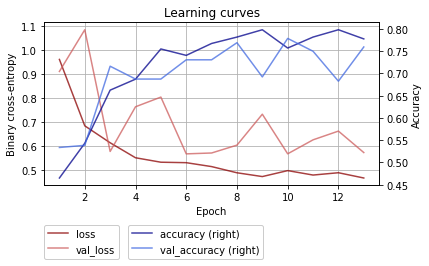

In [ ]:
# Create DataFrame object
df_hist3 = pd.DataFrame.from_dict(history3.history)
df_hist3["Epoch"] = np.arange(1, len(df_hist3) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist3.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

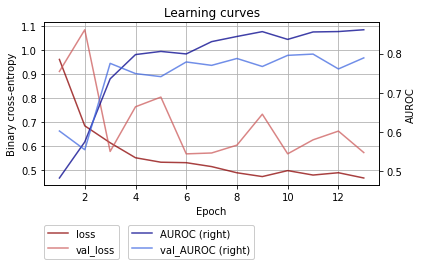

In [ ]:
# Create DataFrame object
df_hist3 = pd.DataFrame.from_dict(history3.history)
df_hist3["Epoch"] = np.arange(1, len(df_hist3) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] 
ax = df_hist3.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
len(cnn3.layers)

8

## 4.4. CNN-V4.
Consider the architecture CNN-V3 with augmentation.

In [ ]:
for layer in augmentation.layers:
    print(layer.name)

random_flip
random_rotation
random_zoom
random_translation
random_contrast


In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v4
cnn4 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn4.build(input_shape)
# Check network
cnn4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (64, 128, 128, 3)         0         
                                                                 
 random_rotation_3 (RandomRo  (64, 128, 128, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (64, 128, 128, 3)         0         
                                                                 
 random_translation_3 (Rando  (64, 128, 128, 3)        0         
 mTranslation)                                                   
                                                                 
 random_contrast_3 (RandomCo  (64, 128, 128, 3)        0         
 ntrast)                                                         
                                                      

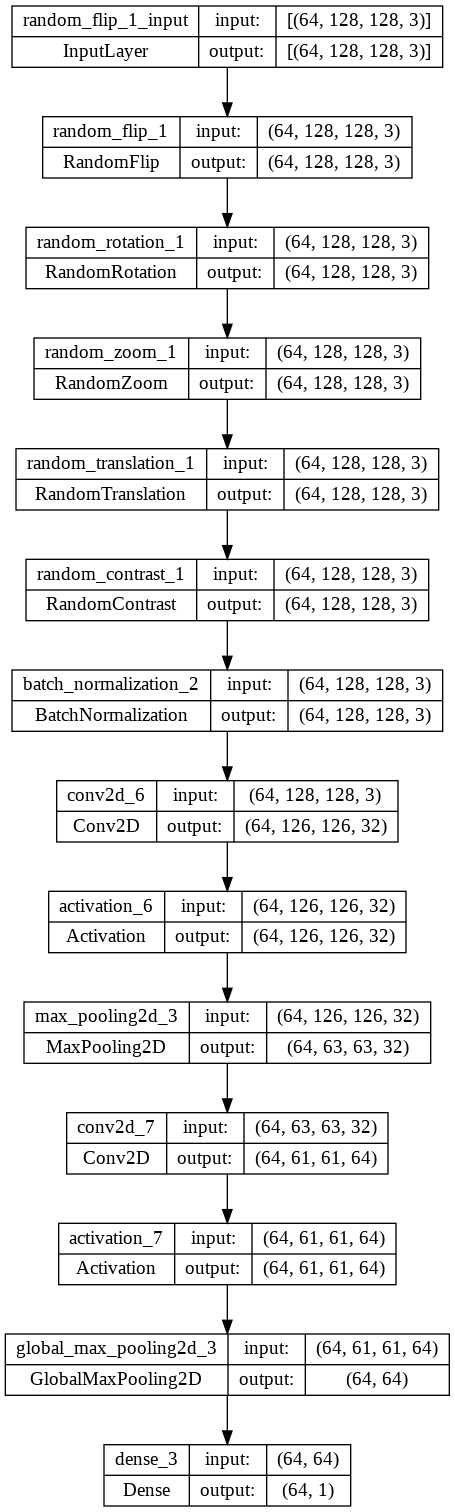

In [ ]:
tf.keras.utils.plot_model(cnn4, show_shapes=True)

The cells below:
1. compiles the model
2. setup calbacks
3. trains the model
4. evaluates the model
5. creates a ``pandas.DataFrame`` from ``history`` dictionary 
6. plots the learning curves.

In [ ]:
# 1.
cnn4.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])

In [ ]:
# 2.
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn4_checkpoint",
    monitor="val_accuracy",
    save_freq="epoch", # default value is 'epoch'
    save_best_only=True
)

In [ ]:
# 3.
epochs = 100
history4 = cnn4.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[early_stopping, model_checkpoint])
cnn4.save("cnn_model.h4")

Epoch 1/100


8/8 [==============================] - ETA: 0s - loss: 0.7321 - accuracy: 0.6235 - recall: 0.7160 - precision: 0.6151 - AUROC: 0.6816

8/8 [==============================] - 33s 3s/step - loss: 0.7321 - accuracy: 0.6235 - recall: 0.7160 - precision: 0.6151 - AUROC: 0.6816 - val_loss: 2.1003 - val_accuracy: 0.5962 - val_recall: 0.1649 - val_precision: 0.8421 - val_AUROC: 0.6772
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.7119 - recall: 0.6720 - precision: 0.7434 - AUROC: 0.7809

8/8 [==============================] - 23s 3s/step - loss: 0.5577 - accuracy: 0.7119 - recall: 0.6720 - precision: 0.7434 - AUROC: 0.7809 - val_loss: 1.1563 - val_accuracy: 0.6635 - val_recall: 0.3299 - val_precision: 0.8649 - val_AUROC: 0.7266
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.7551 - recall: 0.6440 - precision: 0.8429 - AUROC: 0.8076

8/8 [==============================] - 25s 3s/step - loss: 0.5286 - accuracy: 0.7551 - recall: 0.6440 - precision: 0.8429 - AUROC: 0.8076 - val_loss: 0.6364 - val_accuracy: 0.6875 - val_recall: 0.4124 - val_precision: 0.8333 - val_AUROC: 0.7243
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.5091 - accuracy: 0.7551 - recall: 0.7040 - precision: 0.7964 - AUROC: 0.8194

8/8 [==============================] - 26s 3s/step - loss: 0.5091 - accuracy: 0.7551 - recall: 0.7040 - precision: 0.7964 - AUROC: 0.8194 - val_loss: 0.6261 - val_accuracy: 0.7260 - val_recall: 0.5258 - val_precision: 0.8226 - val_AUROC: 0.7632
Epoch 5/100
8/8 [==============================] - 18s 2s/step - loss: 0.4903 - accuracy: 0.7695 - recall: 0.6880 - precision: 0.8350 - AUROC: 0.8346 - val_loss: 0.6562 - val_accuracy: 0.6827 - val_recall: 0.4021 - val_precision: 0.8298 - val_AUROC: 0.7503
Epoch 6/100
8/8 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.7778 - recall: 0.7080 - precision: 0.8349 - AUROC: 0.8323

8/8 [==============================] - 23s 3s/step - loss: 0.4882 - accuracy: 0.7778 - recall: 0.7080 - precision: 0.8349 - AUROC: 0.8323 - val_loss: 0.6407 - val_accuracy: 0.7356 - val_recall: 0.7835 - val_precision: 0.6909 - val_AUROC: 0.8087
Epoch 7/100
8/8 [==============================] - 17s 2s/step - loss: 0.5048 - accuracy: 0.7572 - recall: 0.7040 - precision: 0.8000 - AUROC: 0.8205 - val_loss: 0.7128 - val_accuracy: 0.6827 - val_recall: 0.3918 - val_precision: 0.8444 - val_AUROC: 0.7373
Epoch 8/100
8/8 [==============================] - 19s 2s/step - loss: 0.4844 - accuracy: 0.7881 - recall: 0.7840 - precision: 0.8000 - AUROC: 0.8527 - val_loss: 0.7171 - val_accuracy: 0.7067 - val_recall: 0.4433 - val_precision: 0.8600 - val_AUROC: 0.7486
Epoch 9/100
8/8 [==============================] - 17s 2s/step - loss: 0.4713 - accuracy: 0.7860 - recall: 0.7240 - precision: 0.8380 - AUROC: 0.8481 - val_loss: 0.7042 - val_accuracy: 0.7308 - val_recall: 0.5258 - val_precision: 0.8361 - va

In [ ]:
# 4.
score, acc, rec, prec, auc = cnn4.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn4.evaluate(ds_val, verbose=0)

print("Val loss score: %0.3f" % (score))
print("Val accuracy: %0.3f" % (acc))
print("Val recall: %0.3f" % (rec))
print("Val precision: %0.3f" % (prec))
print("Val AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn4.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.540
Training accuracy: 0.767
Training recall: 0.844
Training precision: 0.740
Training AUROC: 0.860
Val loss score: 0.641
Val accuracy: 0.736
Val recall: 0.784
Val precision: 0.691
Val AUROC: 0.809
Test loss score: 0.662
Test accuracy: 0.715
Test recall: 0.760
Test precision: 0.697
Test AUROC: 0.795


In [ ]:
# 5. 
df_hist4 = pd.DataFrame.from_dict(history4.history)
df_hist4["Epoch"] = np.arange(1, len(df_hist4) + 1, 1)

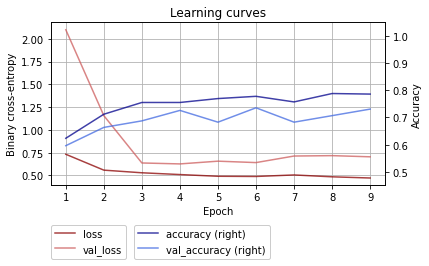

In [ ]:
# 6.
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist4.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

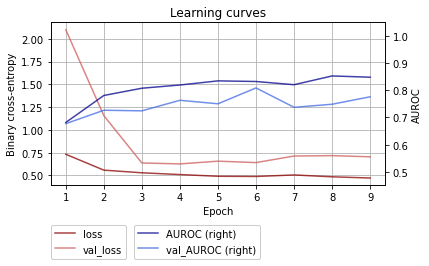

In [ ]:
# 6.
secondary_y = ["AUROC", "val_AUROC"]
ax = df_hist4.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
len(cnn4.layers)

13

## 4.5. CNN-V5.
Consider the architecture CNN-V4 with BatchNormalization() layers before applying the non-linearities.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v5
cnn5 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn5.build(input_shape)
# Check network
cnn5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (64, 128, 128, 3)         0         
                                                                 
 random_rotation_4 (RandomRo  (64, 128, 128, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (64, 128, 128, 3)         0         
                                                                 
 random_translation_4 (Rando  (64, 128, 128, 3)        0         
 mTranslation)                                                   
                                                                 
 random_contrast_4 (RandomCo  (64, 128, 128, 3)        0         
 ntrast)                                                         
                                                      

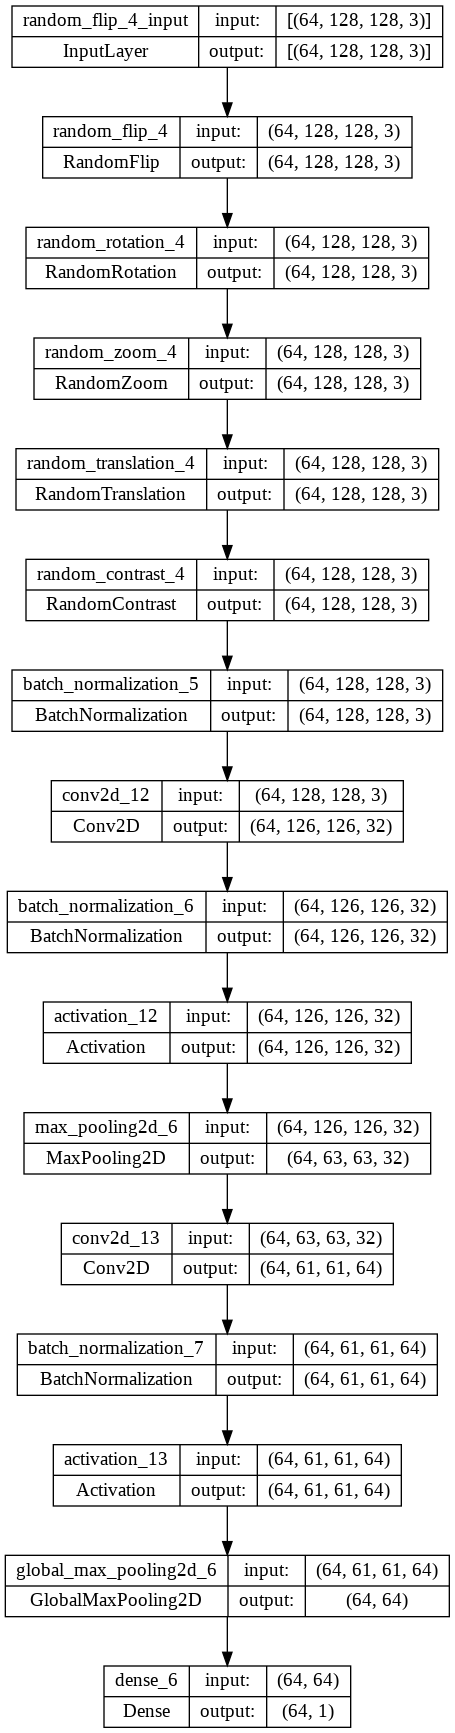

In [ ]:
tf.keras.utils.plot_model(cnn5, show_shapes=True)

The cells below:
1. compiles the model
2. setup calbacks
3. trains the model
4. evaluates the model
5. creates a ``pandas.DataFrame`` from ``history`` dictionary 
6. plots the learning curves.

In [ ]:
# 1.
cnn5.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])

In [ ]:
# 2.
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn5_checkpoint",
    monitor="val_accuracy",
    save_freq="epoch", # default value is 'epoch'
    save_best_only=True
)

In [ ]:
# 3.
epochs = 100
history5 = cnn5.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[early_stopping, model_checkpoint])
cnn5.save("cnn_model.h5")

Epoch 1/100


8/8 [==============================] - ETA: 0s - loss: 1.0744 - accuracy: 0.5782 - recall: 0.5760 - precision: 0.5926 - AUROC: 0.5772

8/8 [==============================] - 39s 4s/step - loss: 1.0744 - accuracy: 0.5782 - recall: 0.5760 - precision: 0.5926 - AUROC: 0.5772 - val_loss: 5.3016 - val_accuracy: 0.5337 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_AUROC: 0.5067
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.5800 - accuracy: 0.6770 - recall: 0.7640 - precision: 0.6609 - AUROC: 0.7670

8/8 [==============================] - 29s 4s/step - loss: 0.5800 - accuracy: 0.6770 - recall: 0.7640 - precision: 0.6609 - AUROC: 0.7670 - val_loss: 3.4323 - val_accuracy: 0.5481 - val_recall: 0.0309 - val_precision: 1.0000 - val_AUROC: 0.5260
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.7551 - recall: 0.6360 - precision: 0.8503 - AUROC: 0.8247

8/8 [==============================] - 30s 4s/step - loss: 0.5152 - accuracy: 0.7551 - recall: 0.6360 - precision: 0.8503 - AUROC: 0.8247 - val_loss: 2.1308 - val_accuracy: 0.5673 - val_recall: 0.0722 - val_precision: 1.0000 - val_AUROC: 0.6512
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.7613 - recall: 0.7040 - precision: 0.8073 - AUROC: 0.8144

8/8 [==============================] - 30s 4s/step - loss: 0.5160 - accuracy: 0.7613 - recall: 0.7040 - precision: 0.8073 - AUROC: 0.8144 - val_loss: 0.9663 - val_accuracy: 0.6538 - val_recall: 0.3196 - val_precision: 0.8378 - val_AUROC: 0.7294
Epoch 5/100
8/8 [==============================] - 22s 3s/step - loss: 0.5108 - accuracy: 0.7675 - recall: 0.7480 - precision: 0.7890 - AUROC: 0.8248 - val_loss: 0.6866 - val_accuracy: 0.6490 - val_recall: 0.8969 - val_precision: 0.5800 - val_AUROC: 0.7889
Epoch 6/100
8/8 [==============================] - 21s 3s/step - loss: 0.5142 - accuracy: 0.7407 - recall: 0.5800 - precision: 0.8735 - AUROC: 0.8338 - val_loss: 0.6661 - val_accuracy: 0.6442 - val_recall: 0.8351 - val_precision: 0.5827 - val_AUROC: 0.8059
Epoch 7/100
8/8 [==============================] - ETA: 0s - loss: 0.5110 - accuracy: 0.7819 - recall: 0.7760 - precision: 0.7951 - AUROC: 0.8432

8/8 [==============================] - 28s 4s/step - loss: 0.5110 - accuracy: 0.7819 - recall: 0.7760 - precision: 0.7951 - AUROC: 0.8432 - val_loss: 0.6222 - val_accuracy: 0.6923 - val_recall: 0.8144 - val_precision: 0.6320 - val_AUROC: 0.8069
Epoch 8/100
8/8 [==============================] - 21s 3s/step - loss: 0.4908 - accuracy: 0.7675 - recall: 0.6680 - precision: 0.8477 - AUROC: 0.8431 - val_loss: 0.6540 - val_accuracy: 0.6587 - val_recall: 0.8763 - val_precision: 0.5903 - val_AUROC: 0.8131
Epoch 9/100
8/8 [==============================] - 21s 3s/step - loss: 0.4668 - accuracy: 0.7757 - recall: 0.7200 - precision: 0.8219 - AUROC: 0.8608 - val_loss: 0.8549 - val_accuracy: 0.4952 - val_recall: 1.0000 - val_precision: 0.4802 - val_AUROC: 0.8159
Epoch 10/100
8/8 [==============================] - 23s 3s/step - loss: 0.4733 - accuracy: 0.8086 - recall: 0.7440 - precision: 0.8651 - AUROC: 0.8485 - val_loss: 0.7410 - val_accuracy: 0.5529 - val_recall: 0.9485 - val_precision: 0.5111 - v

In [ ]:
# 4.
score, acc, rec, prec, auc = cnn5.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn5.evaluate(ds_val, verbose=0)

print("Val loss score: %0.3f" % (score))
print("Val accuracy: %0.3f" % (acc))
print("Val recall: %0.3f" % (rec))
print("Val precision: %0.3f" % (prec))
print("Val AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn5.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.533
Training accuracy: 0.733
Training recall: 0.872
Training precision: 0.690
Training AUROC: 0.856
Val loss score: 0.622
Val accuracy: 0.692
Val recall: 0.814
Val precision: 0.632
Val AUROC: 0.807
Test loss score: 0.629
Test accuracy: 0.680
Test recall: 0.800
Test precision: 0.645
Test AUROC: 0.789


In [ ]:
# 5. 
df_hist5 = pd.DataFrame.from_dict(history5.history)
df_hist5["Epoch"] = np.arange(1, len(df_hist5) + 1, 1)

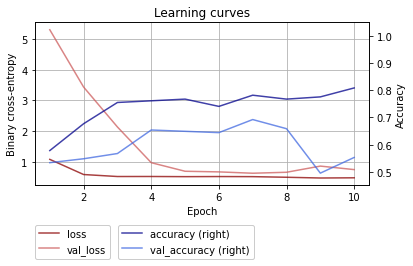

In [ ]:
# 6.
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist5.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

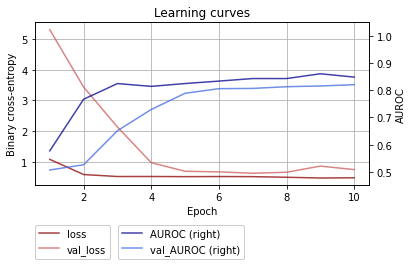

In [ ]:
# 6.
secondary_y = ["AUROC", "val_AUROC"]
ax = df_hist5.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
len(cnn5.layers)

15

## 4.6. CNN-V6.
Creates a deeper architecture made of three repeated blocks of three layers: (convolution, activation, pooling), with augmentation and BatchNormalization() to the head.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v6
cnn6 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: third (closing) block
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn6.build(input_shape)
# Check network
cnn6.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_7 (RandomFlip)  (64, 128, 128, 3)         0         
                                                                 
 random_rotation_7 (RandomRo  (64, 128, 128, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_7 (RandomZoom)  (64, 128, 128, 3)         0         
                                                                 
 random_translation_7 (Rando  (64, 128, 128, 3)        0         
 mTranslation)                                                   
                                                                 
 random_contrast_7 (RandomCo  (64, 128, 128, 3)        0         
 ntrast)                                                         
                                                     

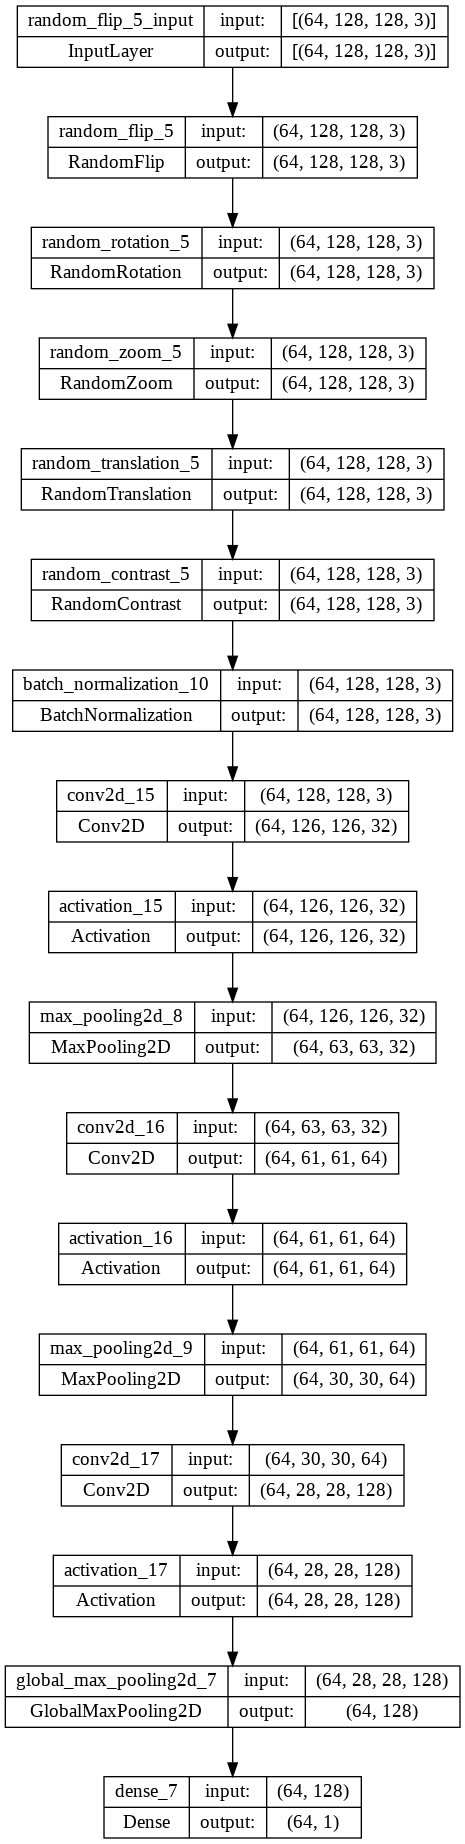

In [ ]:
tf.keras.utils.plot_model(cnn6, show_shapes=True)

The cells below:
1. compiles the model
2. setup calbacks
3. trains the model
4. evaluates the model
5. creates a ``pandas.DataFrame`` from ``history`` dictionary 
6. plots the learning curves.

In [ ]:
# 1.
learning_rate=0.01
cnn6.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])

In [ ]:
# 2.
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=4,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn6_checkpoint",
    monitor="val_accuracy",
    save_freq="epoch", # default value is 'epoch'
    save_best_only=True
)

In [ ]:
# 3.
epochs = 100
history6 = cnn6.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[early_stopping, model_checkpoint])
cnn6.save("cnn_model.h6")

Epoch 1/100


8/8 [==============================] - ETA: 0s - loss: 1.0057 - accuracy: 0.5123 - recall: 0.4680 - precision: 0.5294 - AUROC: 0.5408

8/8 [==============================] - 46s 4s/step - loss: 1.0057 - accuracy: 0.5123 - recall: 0.4680 - precision: 0.5294 - AUROC: 0.5408 - val_loss: 0.6636 - val_accuracy: 0.5673 - val_recall: 0.8247 - val_precision: 0.5229 - val_AUROC: 0.6806
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.6121 - accuracy: 0.6749 - recall: 0.8440 - precision: 0.6394 - AUROC: 0.7728

8/8 [==============================] - 30s 4s/step - loss: 0.6121 - accuracy: 0.6749 - recall: 0.8440 - precision: 0.6394 - AUROC: 0.7728 - val_loss: 0.6205 - val_accuracy: 0.6875 - val_recall: 0.4124 - val_precision: 0.8333 - val_AUROC: 0.6817
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.5578 - accuracy: 0.7243 - recall: 0.6040 - precision: 0.8118 - AUROC: 0.7705

8/8 [==============================] - 31s 4s/step - loss: 0.5578 - accuracy: 0.7243 - recall: 0.6040 - precision: 0.8118 - AUROC: 0.7705 - val_loss: 0.6385 - val_accuracy: 0.7067 - val_recall: 0.5876 - val_precision: 0.7308 - val_AUROC: 0.7335
Epoch 4/100
8/8 [==============================] - 24s 3s/step - loss: 0.5780 - accuracy: 0.7284 - recall: 0.5920 - precision: 0.8315 - AUROC: 0.7832 - val_loss: 0.6084 - val_accuracy: 0.6779 - val_recall: 0.3814 - val_precision: 0.8409 - val_AUROC: 0.6657
Epoch 5/100
8/8 [==============================] - 20s 3s/step - loss: 0.5905 - accuracy: 0.7058 - recall: 0.6000 - precision: 0.7772 - AUROC: 0.7426 - val_loss: 0.6353 - val_accuracy: 0.6394 - val_recall: 0.2577 - val_precision: 0.8929 - val_AUROC: 0.6492
Epoch 6/100
8/8 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.7202 - recall: 0.5320 - precision: 0.8750 - AUROC: 0.7911

8/8 [==============================] - 31s 4s/step - loss: 0.5474 - accuracy: 0.7202 - recall: 0.5320 - precision: 0.8750 - AUROC: 0.7911 - val_loss: 0.6267 - val_accuracy: 0.7163 - val_recall: 0.5567 - val_precision: 0.7714 - val_AUROC: 0.7752
Epoch 7/100
8/8 [==============================] - 22s 3s/step - loss: 0.5310 - accuracy: 0.7675 - recall: 0.6720 - precision: 0.8442 - AUROC: 0.8176 - val_loss: 0.7038 - val_accuracy: 0.6971 - val_recall: 0.3918 - val_precision: 0.9048 - val_AUROC: 0.7405
Epoch 8/100
8/8 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.7613 - recall: 0.6920 - precision: 0.8160 - AUROC: 0.8213

8/8 [==============================] - 30s 4s/step - loss: 0.5077 - accuracy: 0.7613 - recall: 0.6920 - precision: 0.8160 - AUROC: 0.8213 - val_loss: 0.5378 - val_accuracy: 0.7212 - val_recall: 0.5773 - val_precision: 0.7671 - val_AUROC: 0.8015
Epoch 9/100
8/8 [==============================] - 24s 3s/step - loss: 0.4956 - accuracy: 0.7675 - recall: 0.6880 - precision: 0.8309 - AUROC: 0.8237 - val_loss: 0.6070 - val_accuracy: 0.7115 - val_recall: 0.4639 - val_precision: 0.8491 - val_AUROC: 0.7553
Epoch 10/100
8/8 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.7551 - recall: 0.7120 - precision: 0.7911 - AUROC: 0.8219

8/8 [==============================] - 30s 4s/step - loss: 0.5052 - accuracy: 0.7551 - recall: 0.7120 - precision: 0.7911 - AUROC: 0.8219 - val_loss: 0.6215 - val_accuracy: 0.7356 - val_recall: 0.5155 - val_precision: 0.8621 - val_AUROC: 0.7583
Epoch 11/100
8/8 [==============================] - ETA: 0s - loss: 0.4572 - accuracy: 0.7881 - recall: 0.7520 - precision: 0.8210 - AUROC: 0.8552

8/8 [==============================] - 29s 4s/step - loss: 0.4572 - accuracy: 0.7881 - recall: 0.7520 - precision: 0.8210 - AUROC: 0.8552 - val_loss: 0.5587 - val_accuracy: 0.7692 - val_recall: 0.6082 - val_precision: 0.8551 - val_AUROC: 0.8002
Epoch 12/100
8/8 [==============================] - ETA: 0s - loss: 0.4624 - accuracy: 0.7798 - recall: 0.7520 - precision: 0.8069 - AUROC: 0.8472

8/8 [==============================] - 31s 4s/step - loss: 0.4624 - accuracy: 0.7798 - recall: 0.7520 - precision: 0.8069 - AUROC: 0.8472 - val_loss: 0.5369 - val_accuracy: 0.7788 - val_recall: 0.6701 - val_precision: 0.8228 - val_AUROC: 0.8169
Epoch 13/100
8/8 [==============================] - 21s 3s/step - loss: 0.4751 - accuracy: 0.7695 - recall: 0.6640 - precision: 0.8557 - AUROC: 0.8450 - val_loss: 0.5758 - val_accuracy: 0.7596 - val_recall: 0.7320 - val_precision: 0.7474 - val_AUROC: 0.8193
Epoch 14/100
8/8 [==============================] - 21s 3s/step - loss: 0.4816 - accuracy: 0.7757 - recall: 0.7080 - precision: 0.8310 - AUROC: 0.8389 - val_loss: 0.5521 - val_accuracy: 0.7644 - val_recall: 0.5876 - val_precision: 0.8636 - val_AUROC: 0.8056
Epoch 15/100
8/8 [==============================] - 21s 3s/step - loss: 0.4720 - accuracy: 0.7798 - recall: 0.7400 - precision: 0.8150 - AUROC: 0.8489 - val_loss: 0.5555 - val_accuracy: 0.7596 - val_recall: 0.5773 - val_precision: 0.8615 -

In [ ]:
# 4.
score, acc, rec, prec, auc = cnn6.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn6.evaluate(ds_val, verbose=0)

print("Val loss score: %0.3f" % (score))
print("Val accuracy: %0.3f" % (acc))
print("Val recall: %0.3f" % (rec))
print("Val precision: %0.3f" % (prec))
print("Val AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn6.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.443
Training accuracy: 0.792
Training recall: 0.772
Training precision: 0.814
Training AUROC: 0.864
Val loss score: 0.537
Val accuracy: 0.779
Val recall: 0.670
Val precision: 0.823
Val AUROC: 0.817
Test loss score: 0.605
Test accuracy: 0.720
Test recall: 0.680
Test precision: 0.739
Test AUROC: 0.776


In [ ]:
# 5. 
df_hist6 = pd.DataFrame.from_dict(history6.history)
df_hist6["Epoch"] = np.arange(1, len(df_hist6) + 1, 1)

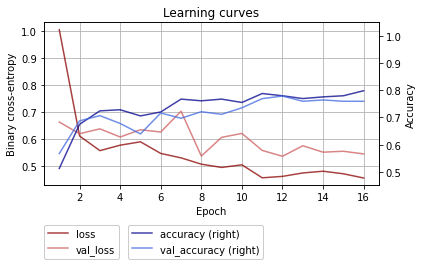

In [ ]:
# 6.
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist6.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

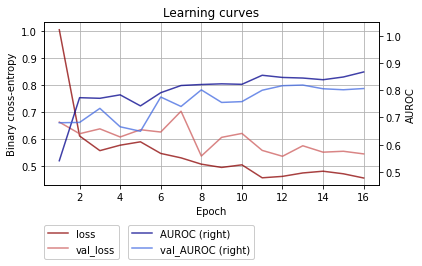

In [ ]:
# 6.
secondary_y = ["AUROC", "val_AUROC"] 
ax = df_hist6.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
len(cnn6.layers)

16

## 4.7. CNN-V7.
Consider the architecture CNN-V6 with ``BatchNormalization()`` layers before applying the non-linearities.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v7
cnn7 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: third (closing) block
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn7.build(input_shape)
# Check network
cnn7.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_10 (RandomFlip)  (64, 128, 128, 3)        0         
                                                                 
 random_rotation_10 (RandomR  (64, 128, 128, 3)        0         
 otation)                                                        
                                                                 
 random_zoom_10 (RandomZoom)  (64, 128, 128, 3)        0         
                                                                 
 random_translation_10 (Rand  (64, 128, 128, 3)        0         
 omTranslation)                                                  
                                                                 
 random_contrast_10 (RandomC  (64, 128, 128, 3)        0         
 ontrast)                                                        
                                                     

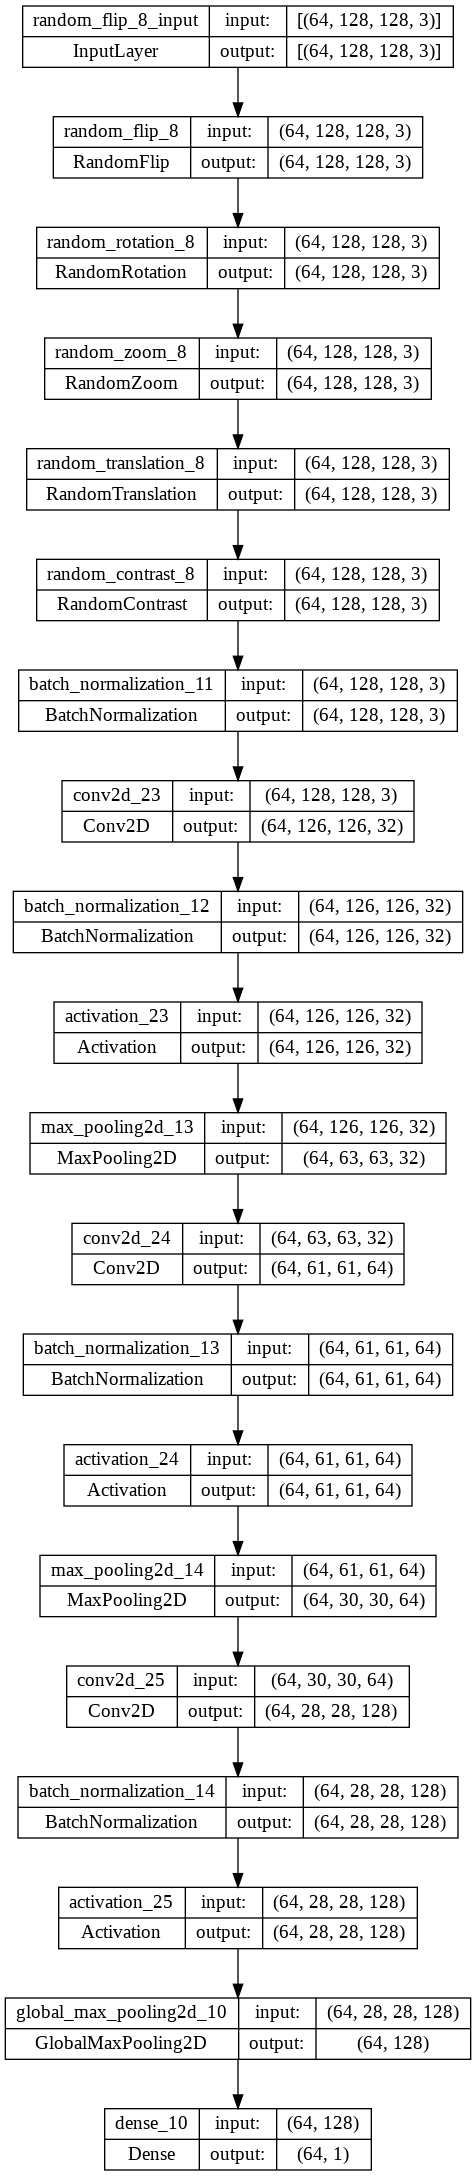

In [ ]:
tf.keras.utils.plot_model(cnn7, show_shapes=True)

The cells below:
1. compiles the model
2. setup calbacks
3. trains the model
4. evaluates the model
5. creates a ``pandas.DataFrame`` from ``history`` dictionary 
6. plots the learning curves.

In [ ]:
# 1.
cnn7.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])

In [ ]:
# 2.
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn7_checkpoint",
    monitor="val_accuracy",
    save_freq="epoch", # default value is 'epoch'
    save_best_only=True
)

In [ ]:
# 3.
epochs = 100
history7 = cnn7.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[early_stopping, model_checkpoint])
cnn7.save("cnn_model.h7")

Epoch 1/100


8/8 [==============================] - ETA: 0s - loss: 1.1741 - accuracy: 0.5823 - recall: 0.5240 - precision: 0.6093 - AUROC: 0.5692

8/8 [==============================] - 52s 5s/step - loss: 1.1741 - accuracy: 0.5823 - recall: 0.5240 - precision: 0.6093 - AUROC: 0.5692 - val_loss: 67.6552 - val_accuracy: 0.4663 - val_recall: 1.0000 - val_precision: 0.4663 - val_AUROC: 0.5000
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.6787 - accuracy: 0.5473 - recall: 0.6280 - precision: 0.5528 - AUROC: 0.6239

8/8 [==============================] - 34s 4s/step - loss: 0.6787 - accuracy: 0.5473 - recall: 0.6280 - precision: 0.5528 - AUROC: 0.6239 - val_loss: 7.2918 - val_accuracy: 0.5337 - val_recall: 0.0825 - val_precision: 0.5000 - val_AUROC: 0.4806
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.5993 - accuracy: 0.6235 - recall: 0.7960 - precision: 0.6012 - AUROC: 0.7431

8/8 [==============================] - 36s 5s/step - loss: 0.5993 - accuracy: 0.6235 - recall: 0.7960 - precision: 0.6012 - AUROC: 0.7431 - val_loss: 2.1127 - val_accuracy: 0.5385 - val_recall: 0.3918 - val_precision: 0.5067 - val_AUROC: 0.5719
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.5912 - accuracy: 0.6996 - recall: 0.5920 - precision: 0.7708 - AUROC: 0.7517

8/8 [==============================] - 35s 4s/step - loss: 0.5912 - accuracy: 0.6996 - recall: 0.5920 - precision: 0.7708 - AUROC: 0.7517 - val_loss: 1.6670 - val_accuracy: 0.5769 - val_recall: 0.4536 - val_precision: 0.5570 - val_AUROC: 0.6198
Epoch 5/100
8/8 [==============================] - 27s 3s/step - loss: 0.5428 - accuracy: 0.7181 - recall: 0.6600 - precision: 0.7604 - AUROC: 0.7861 - val_loss: 2.2663 - val_accuracy: 0.5673 - val_recall: 0.1959 - val_precision: 0.6129 - val_AUROC: 0.5502
Epoch 6/100
8/8 [==============================] - ETA: 0s - loss: 0.5200 - accuracy: 0.7305 - recall: 0.6800 - precision: 0.7692 - AUROC: 0.8110

8/8 [==============================] - 36s 5s/step - loss: 0.5200 - accuracy: 0.7305 - recall: 0.6800 - precision: 0.7692 - AUROC: 0.8110 - val_loss: 1.1848 - val_accuracy: 0.6010 - val_recall: 0.4021 - val_precision: 0.6094 - val_AUROC: 0.6284
Epoch 7/100
8/8 [==============================] - ETA: 0s - loss: 0.5167 - accuracy: 0.7407 - recall: 0.6920 - precision: 0.7793 - AUROC: 0.8148

8/8 [==============================] - 35s 4s/step - loss: 0.5167 - accuracy: 0.7407 - recall: 0.6920 - precision: 0.7793 - AUROC: 0.8148 - val_loss: 0.9050 - val_accuracy: 0.6250 - val_recall: 0.5979 - val_precision: 0.5979 - val_AUROC: 0.6961
Epoch 8/100
8/8 [==============================] - 26s 3s/step - loss: 0.5307 - accuracy: 0.7469 - recall: 0.7240 - precision: 0.7702 - AUROC: 0.8088 - val_loss: 1.0098 - val_accuracy: 0.5817 - val_recall: 0.8660 - val_precision: 0.5316 - val_AUROC: 0.7234
Epoch 9/100
8/8 [==============================] - 29s 3s/step - loss: 0.5459 - accuracy: 0.7202 - recall: 0.6000 - precision: 0.8065 - AUROC: 0.8026 - val_loss: 0.9498 - val_accuracy: 0.6058 - val_recall: 0.8351 - val_precision: 0.5510 - val_AUROC: 0.7209
Epoch 10/100
8/8 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.7284 - recall: 0.6480 - precision: 0.7864 - AUROC: 0.8327

8/8 [==============================] - 35s 4s/step - loss: 0.5043 - accuracy: 0.7284 - recall: 0.6480 - precision: 0.7864 - AUROC: 0.8327 - val_loss: 0.7668 - val_accuracy: 0.6298 - val_recall: 0.7216 - val_precision: 0.5833 - val_AUROC: 0.7330
Epoch 11/100
8/8 [==============================] - ETA: 0s - loss: 0.5346 - accuracy: 0.7346 - recall: 0.7480 - precision: 0.7391 - AUROC: 0.8231

8/8 [==============================] - 35s 4s/step - loss: 0.5346 - accuracy: 0.7346 - recall: 0.7480 - precision: 0.7391 - AUROC: 0.8231 - val_loss: 0.6579 - val_accuracy: 0.7115 - val_recall: 0.6289 - val_precision: 0.7176 - val_AUROC: 0.7328
Epoch 12/100
8/8 [==============================] - 27s 3s/step - loss: 0.5152 - accuracy: 0.7428 - recall: 0.6720 - precision: 0.7962 - AUROC: 0.8252 - val_loss: 0.9746 - val_accuracy: 0.5721 - val_recall: 0.9278 - val_precision: 0.5233 - val_AUROC: 0.7544
Epoch 13/100
8/8 [==============================] - 26s 3s/step - loss: 0.4994 - accuracy: 0.7716 - recall: 0.7120 - precision: 0.8203 - AUROC: 0.8531 - val_loss: 0.6064 - val_accuracy: 0.7067 - val_recall: 0.5567 - val_precision: 0.7500 - val_AUROC: 0.7346
Epoch 14/100
8/8 [==============================] - 27s 3s/step - loss: 0.4907 - accuracy: 0.7469 - recall: 0.7160 - precision: 0.7749 - AUROC: 0.8466 - val_loss: 0.6303 - val_accuracy: 0.6298 - val_recall: 0.7010 - val_precision: 0.5862 -

In [ ]:
# 4.
score, acc, rec, prec, auc = cnn7.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn7.evaluate(ds_val, verbose=0)

print("Val loss score: %0.3f" % (score))
print("Val accuracy: %0.3f" % (acc))
print("Val recall: %0.3f" % (rec))
print("Val precision: %0.3f" % (prec))
print("Val AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn7.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.528
Training accuracy: 0.733
Training recall: 0.660
Training precision: 0.786
Training AUROC: 0.819
Val loss score: 0.658
Val accuracy: 0.712
Val recall: 0.629
Val precision: 0.718
Val AUROC: 0.733
Test loss score: 0.593
Test accuracy: 0.720
Test recall: 0.610
Test precision: 0.782
Test AUROC: 0.791


In [ ]:
# 5. 
df_hist7 = pd.DataFrame.from_dict(history7.history)
df_hist7["Epoch"] = np.arange(1, len(df_hist7) + 1, 1)

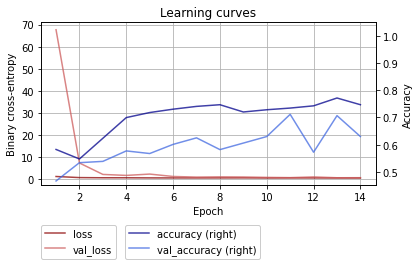

In [ ]:
# 6.
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist7.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

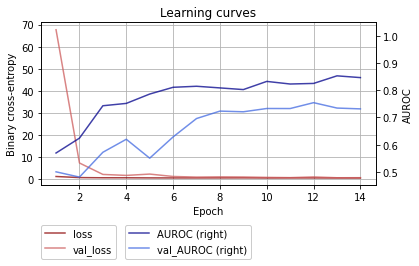

In [ ]:
# 6.
secondary_y = ["AUROC", "val_AUROC"] 
ax = df_hist7.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
len(cnn7.layers)

19

## 4.8. CNN-V8.
Consider the architecture CNN-V7 with regularization and dropout.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v8
cnn8 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: third (closing) block
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn8.build(input_shape)
# Check network
cnn8.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_11 (RandomFlip)  (64, 128, 128, 3)        0         
                                                                 
 random_rotation_11 (RandomR  (64, 128, 128, 3)        0         
 otation)                                                        
                                                                 
 random_zoom_11 (RandomZoom)  (64, 128, 128, 3)        0         
                                                                 
 random_translation_11 (Rand  (64, 128, 128, 3)        0         
 omTranslation)                                                  
                                                                 
 random_contrast_11 (RandomC  (64, 128, 128, 3)        0         
 ontrast)                                                        
                                                     

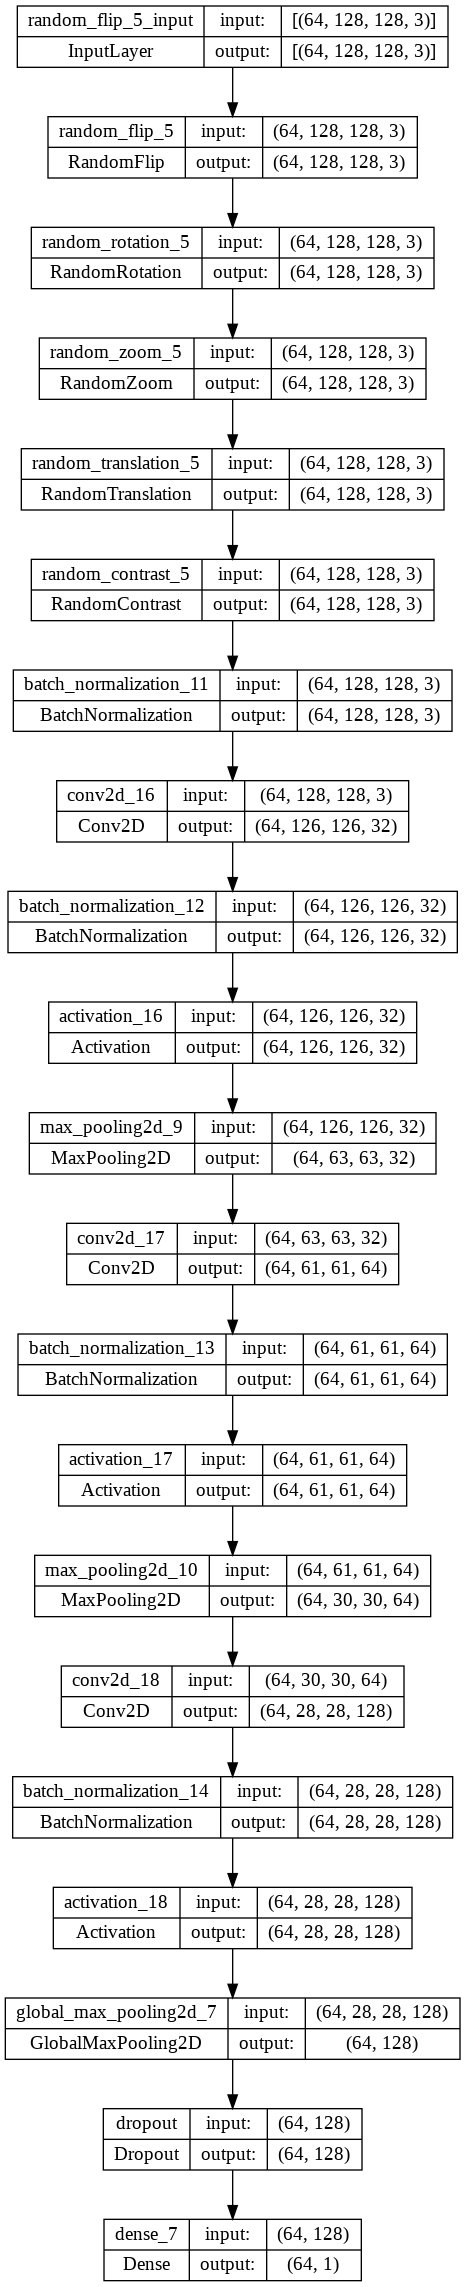

In [ ]:
tf.keras.utils.plot_model(cnn8, show_shapes=True)

The cells below:
1. compiles the model
2. setup calbacks
3. trains the model
4. evaluates the model
5. creates a ``pandas.DataFrame`` from ``history`` dictionary 
6. plots the learning curves.

In [ ]:
# 1.
cnn8.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])

In [ ]:
# 2.
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn8_checkpoint",
    monitor="val_accuracy",
    save_freq="epoch", # default value is 'epoch'
    save_best_only=True
)

In [ ]:
# 3.
epochs = 100
history8 = cnn8.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[early_stopping, model_checkpoint])
cnn8.save("cnn_model.h8")

Epoch 1/100


8/8 [==============================] - ETA: 0s - loss: 1.7069 - accuracy: 0.4877 - recall: 0.4720 - precision: 0.5021 - AUROC: 0.4911

8/8 [==============================] - 44s 5s/step - loss: 1.7069 - accuracy: 0.4877 - recall: 0.4720 - precision: 0.5021 - AUROC: 0.4911 - val_loss: 260.9193 - val_accuracy: 0.4663 - val_recall: 1.0000 - val_precision: 0.4663 - val_AUROC: 0.5000
Epoch 2/100
8/8 [==============================] - 29s 3s/step - loss: 0.8280 - accuracy: 0.5761 - recall: 0.5840 - precision: 0.5887 - AUROC: 0.6031 - val_loss: 25.1447 - val_accuracy: 0.4663 - val_recall: 1.0000 - val_precision: 0.4663 - val_AUROC: 0.5000
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.7146 - accuracy: 0.6728 - recall: 0.6280 - precision: 0.7040 - AUROC: 0.7053

8/8 [==============================] - 35s 4s/step - loss: 0.7146 - accuracy: 0.6728 - recall: 0.6280 - precision: 0.7040 - AUROC: 0.7053 - val_loss: 11.4310 - val_accuracy: 0.5337 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_AUROC: 0.5103
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.7428 - recall: 0.7640 - precision: 0.7432 - AUROC: 0.7974

8/8 [==============================] - 36s 4s/step - loss: 0.5956 - accuracy: 0.7428 - recall: 0.7640 - precision: 0.7432 - AUROC: 0.7974 - val_loss: 9.3346 - val_accuracy: 0.5385 - val_recall: 0.0103 - val_precision: 1.0000 - val_AUROC: 0.5258
Epoch 5/100
8/8 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.7243 - recall: 0.7080 - precision: 0.7437 - AUROC: 0.7953

8/8 [==============================] - 37s 5s/step - loss: 0.6015 - accuracy: 0.7243 - recall: 0.7080 - precision: 0.7437 - AUROC: 0.7953 - val_loss: 8.2524 - val_accuracy: 0.5529 - val_recall: 0.0412 - val_precision: 1.0000 - val_AUROC: 0.5258
Epoch 6/100
8/8 [==============================] - ETA: 0s - loss: 0.5718 - accuracy: 0.7428 - recall: 0.6800 - precision: 0.7907 - AUROC: 0.8147

8/8 [==============================] - 36s 5s/step - loss: 0.5718 - accuracy: 0.7428 - recall: 0.6800 - precision: 0.7907 - AUROC: 0.8147 - val_loss: 4.3898 - val_accuracy: 0.5721 - val_recall: 0.0825 - val_precision: 1.0000 - val_AUROC: 0.5471
Epoch 7/100
8/8 [==============================] - 25s 3s/step - loss: 0.6033 - accuracy: 0.7222 - recall: 0.7120 - precision: 0.7386 - AUROC: 0.8083 - val_loss: 4.2091 - val_accuracy: 0.5577 - val_recall: 0.0515 - val_precision: 1.0000 - val_AUROC: 0.5325
Epoch 8/100
8/8 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.7346 - recall: 0.6800 - precision: 0.7763 - AUROC: 0.8141

8/8 [==============================] - 38s 5s/step - loss: 0.5831 - accuracy: 0.7346 - recall: 0.6800 - precision: 0.7763 - AUROC: 0.8141 - val_loss: 2.3824 - val_accuracy: 0.5817 - val_recall: 0.1134 - val_precision: 0.9167 - val_AUROC: 0.5649
Epoch 9/100
8/8 [==============================] - ETA: 0s - loss: 0.5379 - accuracy: 0.7654 - recall: 0.7040 - precision: 0.8148 - AUROC: 0.8467

8/8 [==============================] - 35s 4s/step - loss: 0.5379 - accuracy: 0.7654 - recall: 0.7040 - precision: 0.8148 - AUROC: 0.8467 - val_loss: 1.3944 - val_accuracy: 0.6010 - val_recall: 0.1753 - val_precision: 0.8500 - val_AUROC: 0.6188
Epoch 10/100
8/8 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.7654 - recall: 0.7320 - precision: 0.7957 - AUROC: 0.8217

8/8 [==============================] - 36s 5s/step - loss: 0.5787 - accuracy: 0.7654 - recall: 0.7320 - precision: 0.7957 - AUROC: 0.8217 - val_loss: 1.0953 - val_accuracy: 0.6106 - val_recall: 0.1959 - val_precision: 0.8636 - val_AUROC: 0.6228
Epoch 11/100
8/8 [==============================] - ETA: 0s - loss: 0.5657 - accuracy: 0.7551 - recall: 0.6920 - precision: 0.8047 - AUROC: 0.8218

8/8 [==============================] - 39s 4s/step - loss: 0.5657 - accuracy: 0.7551 - recall: 0.6920 - precision: 0.8047 - AUROC: 0.8218 - val_loss: 0.6929 - val_accuracy: 0.6875 - val_recall: 0.3918 - val_precision: 0.8636 - val_AUROC: 0.7078
Epoch 12/100
8/8 [==============================] - 26s 3s/step - loss: 0.5288 - accuracy: 0.7634 - recall: 0.7360 - precision: 0.7897 - AUROC: 0.8502 - val_loss: 1.0120 - val_accuracy: 0.6298 - val_recall: 0.2371 - val_precision: 0.8846 - val_AUROC: 0.6773
Epoch 13/100
8/8 [==============================] - 26s 3s/step - loss: 0.6117 - accuracy: 0.7305 - recall: 0.6200 - precision: 0.8115 - AUROC: 0.7826 - val_loss: 1.0325 - val_accuracy: 0.6154 - val_recall: 0.2062 - val_precision: 0.8696 - val_AUROC: 0.6635
Epoch 14/100
8/8 [==============================] - 28s 3s/step - loss: 0.5735 - accuracy: 0.7510 - recall: 0.6800 - precision: 0.8057 - AUROC: 0.8116 - val_loss: 1.5679 - val_accuracy: 0.5962 - val_recall: 0.1546 - val_precision: 0.8824 -

In [ ]:
# 4.
score, acc, rec, prec, auc = cnn8.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn8.evaluate(ds_val, verbose=0)

print("Val loss score: %0.3f" % (score))
print("Val accuracy: %0.3f" % (acc))
print("Val recall: %0.3f" % (rec))
print("Val precision: %0.3f" % (prec))
print("Val AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn8.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.651
Training accuracy: 0.693
Training recall: 0.464
Training precision: 0.885
Training AUROC: 0.768
Val loss score: 0.693
Val accuracy: 0.688
Val recall: 0.392
Val precision: 0.864
Val AUROC: 0.708
Test loss score: 0.648
Test accuracy: 0.685
Test recall: 0.460
Test precision: 0.836
Test AUROC: 0.769


In [ ]:
# 5. 
df_hist8 = pd.DataFrame.from_dict(history8.history)
df_hist8["Epoch"] = np.arange(1, len(df_hist8) + 1, 1)

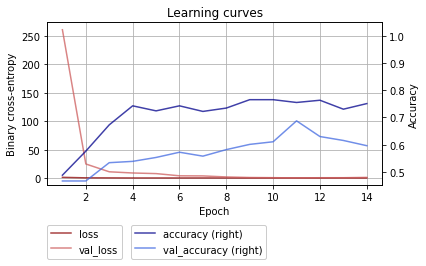

In [ ]:
# 6.
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist8.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

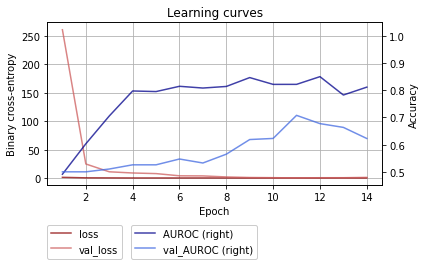

In [ ]:
# 6.
secondary_y = ["AUROC", "val_AUROC"]
ax = df_hist8.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
len(cnn8.layers)

20

## 4.9. CNN-V9.
Consider the architecture CNN-V5 with regularization and dropout.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v9
cnn9 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second (closing) block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn9.build(input_shape)
# Check network
cnn9.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_13 (RandomFlip)  (64, 128, 128, 3)        0         
                                                                 
 random_rotation_13 (RandomR  (64, 128, 128, 3)        0         
 otation)                                                        
                                                                 
 random_zoom_13 (RandomZoom)  (64, 128, 128, 3)        0         
                                                                 
 random_translation_13 (Rand  (64, 128, 128, 3)        0         
 omTranslation)                                                  
                                                                 
 random_contrast_13 (RandomC  (64, 128, 128, 3)        0         
 ontrast)                                                        
                                                     

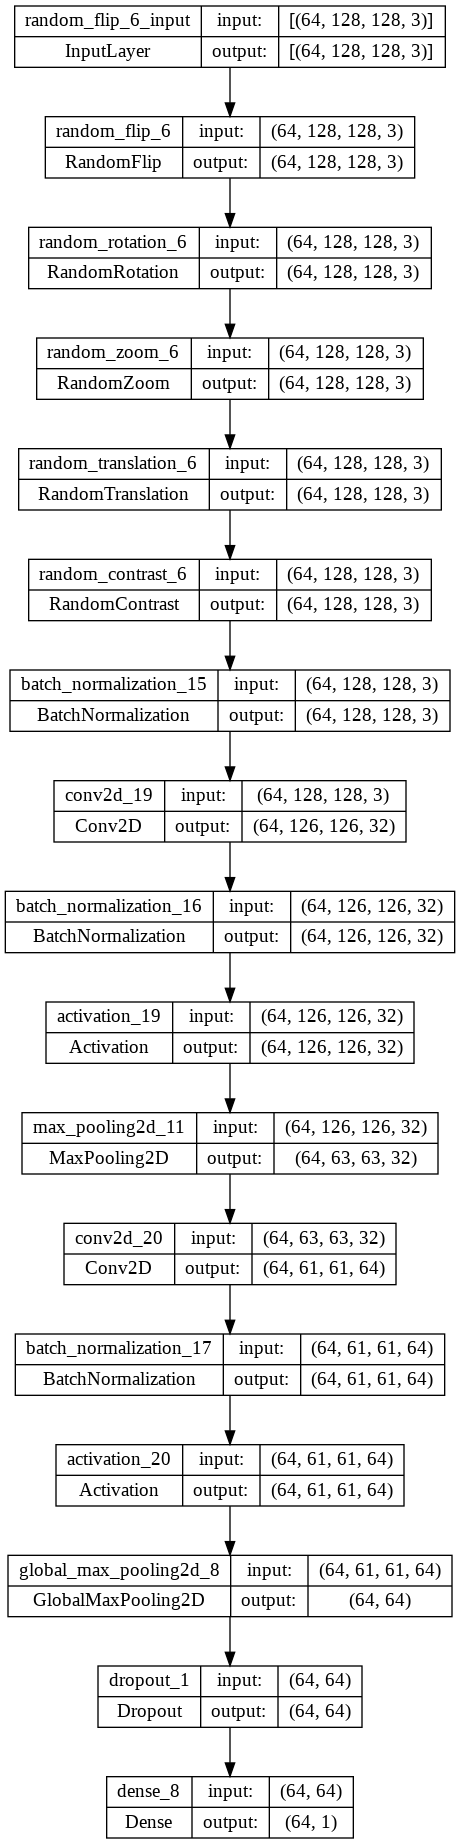

In [ ]:
tf.keras.utils.plot_model(cnn9, show_shapes=True)

The cells below:
1. compiles the model
2. setup calbacks
3. trains the model
4. evaluates the model
5. creates a ``pandas.DataFrame`` from ``history`` dictionary 
6. plots the learning curves.

In [ ]:
# 1.
cnn9.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])

In [ ]:
# 2.
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=4,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn9_checkpoint",
    monitor="val_accuracy",
    save_freq="epoch", # default value is 'epoch'
    save_best_only=True
)

In [ ]:
# 3.
epochs = 100
history9 = cnn9.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[early_stopping, model_checkpoint])
cnn9.save("cnn_model.h9")

Epoch 1/100


8/8 [==============================] - ETA: 0s - loss: 1.2207 - accuracy: 0.5123 - recall: 0.5160 - precision: 0.5265 - AUROC: 0.5295

8/8 [==============================] - 44s 4s/step - loss: 1.2207 - accuracy: 0.5123 - recall: 0.5160 - precision: 0.5265 - AUROC: 0.5295 - val_loss: 6.4049 - val_accuracy: 0.4663 - val_recall: 1.0000 - val_precision: 0.4663 - val_AUROC: 0.4993
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.5864 - recall: 0.7480 - precision: 0.5754 - AUROC: 0.6291

8/8 [==============================] - 31s 4s/step - loss: 0.7436 - accuracy: 0.5864 - recall: 0.7480 - precision: 0.5754 - AUROC: 0.6291 - val_loss: 2.5341 - val_accuracy: 0.5481 - val_recall: 0.0309 - val_precision: 1.0000 - val_AUROC: 0.5472
Epoch 3/100
8/8 [==============================] - 22s 3s/step - loss: 0.6861 - accuracy: 0.6337 - recall: 0.6760 - precision: 0.6353 - AUROC: 0.7030 - val_loss: 4.6406 - val_accuracy: 0.5385 - val_recall: 0.0103 - val_precision: 1.0000 - val_AUROC: 0.5346
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.6474 - accuracy: 0.6831 - recall: 0.6440 - precision: 0.7124 - AUROC: 0.7419

8/8 [==============================] - 29s 4s/step - loss: 0.6474 - accuracy: 0.6831 - recall: 0.6440 - precision: 0.7124 - AUROC: 0.7419 - val_loss: 2.0258 - val_accuracy: 0.5865 - val_recall: 0.1340 - val_precision: 0.8667 - val_AUROC: 0.6685
Epoch 5/100
8/8 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.6996 - recall: 0.6920 - precision: 0.7149 - AUROC: 0.7703

8/8 [==============================] - 32s 4s/step - loss: 0.6042 - accuracy: 0.6996 - recall: 0.6920 - precision: 0.7149 - AUROC: 0.7703 - val_loss: 1.4184 - val_accuracy: 0.5913 - val_recall: 0.1959 - val_precision: 0.7308 - val_AUROC: 0.7076
Epoch 6/100
8/8 [==============================] - ETA: 0s - loss: 0.6011 - accuracy: 0.7325 - recall: 0.6960 - precision: 0.7632 - AUROC: 0.7816

8/8 [==============================] - 32s 4s/step - loss: 0.6011 - accuracy: 0.7325 - recall: 0.6960 - precision: 0.7632 - AUROC: 0.7816 - val_loss: 0.8410 - val_accuracy: 0.6827 - val_recall: 0.4124 - val_precision: 0.8163 - val_AUROC: 0.7385
Epoch 7/100
8/8 [==============================] - ETA: 0s - loss: 0.5484 - accuracy: 0.7490 - recall: 0.7120 - precision: 0.7807 - AUROC: 0.8111

8/8 [==============================] - 30s 4s/step - loss: 0.5484 - accuracy: 0.7490 - recall: 0.7120 - precision: 0.7807 - AUROC: 0.8111 - val_loss: 0.6074 - val_accuracy: 0.7308 - val_recall: 0.5773 - val_precision: 0.7887 - val_AUROC: 0.7600
Epoch 8/100
8/8 [==============================] - ETA: 0s - loss: 0.5935 - accuracy: 0.6893 - recall: 0.7200 - precision: 0.6897 - AUROC: 0.7840

8/8 [==============================] - 33s 4s/step - loss: 0.5935 - accuracy: 0.6893 - recall: 0.7200 - precision: 0.6897 - AUROC: 0.7840 - val_loss: 0.6066 - val_accuracy: 0.7452 - val_recall: 0.5979 - val_precision: 0.8056 - val_AUROC: 0.7685
Epoch 9/100
8/8 [==============================] - 21s 3s/step - loss: 0.5632 - accuracy: 0.7387 - recall: 0.6600 - precision: 0.7971 - AUROC: 0.8010 - val_loss: 0.5967 - val_accuracy: 0.7404 - val_recall: 0.6701 - val_precision: 0.7471 - val_AUROC: 0.7777
Epoch 10/100
8/8 [==============================] - 21s 3s/step - loss: 0.5015 - accuracy: 0.7798 - recall: 0.7480 - precision: 0.8095 - AUROC: 0.8420 - val_loss: 0.6835 - val_accuracy: 0.6250 - val_recall: 0.8351 - val_precision: 0.5664 - val_AUROC: 0.7868
Epoch 11/100
8/8 [==============================] - 21s 3s/step - loss: 0.5231 - accuracy: 0.7490 - recall: 0.7200 - precision: 0.7759 - AUROC: 0.8308 - val_loss: 0.8658 - val_accuracy: 0.4760 - val_recall: 0.9794 - val_precision: 0.4703 - 

8/8 [==============================] - 29s 4s/step - loss: 0.5023 - accuracy: 0.7551 - recall: 0.7160 - precision: 0.7885 - AUROC: 0.8332 - val_loss: 0.5774 - val_accuracy: 0.7548 - val_recall: 0.6495 - val_precision: 0.7875 - val_AUROC: 0.7796
Epoch 13/100
8/8 [==============================] - 21s 3s/step - loss: 0.4900 - accuracy: 0.7531 - recall: 0.7280 - precision: 0.7778 - AUROC: 0.8498 - val_loss: 0.5749 - val_accuracy: 0.7548 - val_recall: 0.6495 - val_precision: 0.7875 - val_AUROC: 0.7851
Epoch 14/100
8/8 [==============================] - 23s 3s/step - loss: 0.5283 - accuracy: 0.7593 - recall: 0.7360 - precision: 0.7830 - AUROC: 0.8290 - val_loss: 0.5944 - val_accuracy: 0.7308 - val_recall: 0.7526 - val_precision: 0.6952 - val_AUROC: 0.7883
Epoch 15/100
8/8 [==============================] - ETA: 0s - loss: 0.4981 - accuracy: 0.7737 - recall: 0.6840 - precision: 0.8465 - AUROC: 0.8467

8/8 [==============================] - 30s 4s/step - loss: 0.4981 - accuracy: 0.7737 - recall: 0.6840 - precision: 0.8465 - AUROC: 0.8467 - val_loss: 0.5835 - val_accuracy: 0.7596 - val_recall: 0.7320 - val_precision: 0.7474 - val_AUROC: 0.7987
Epoch 16/100
8/8 [==============================] - 21s 3s/step - loss: 0.5242 - accuracy: 0.7572 - recall: 0.7240 - precision: 0.7870 - AUROC: 0.8336 - val_loss: 0.5985 - val_accuracy: 0.7356 - val_recall: 0.7732 - val_precision: 0.6944 - val_AUROC: 0.8113
Epoch 17/100
8/8 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.7716 - recall: 0.7320 - precision: 0.8062 - AUROC: 0.8392

8/8 [==============================] - 29s 4s/step - loss: 0.5054 - accuracy: 0.7716 - recall: 0.7320 - precision: 0.8062 - AUROC: 0.8392 - val_loss: 0.5649 - val_accuracy: 0.7644 - val_recall: 0.7113 - val_precision: 0.7667 - val_AUROC: 0.7990
Epoch 18/100
8/8 [==============================] - 22s 3s/step - loss: 0.5079 - accuracy: 0.7654 - recall: 0.7240 - precision: 0.8009 - AUROC: 0.8418 - val_loss: 0.5999 - val_accuracy: 0.7163 - val_recall: 0.7526 - val_precision: 0.6759 - val_AUROC: 0.8019
Epoch 19/100
8/8 [==============================] - 21s 3s/step - loss: 0.5016 - accuracy: 0.7901 - recall: 0.7200 - precision: 0.8491 - AUROC: 0.8492 - val_loss: 0.6277 - val_accuracy: 0.7019 - val_recall: 0.8454 - val_precision: 0.6357 - val_AUROC: 0.8153
Epoch 20/100
8/8 [==============================] - 21s 3s/step - loss: 0.5153 - accuracy: 0.7634 - recall: 0.7560 - precision: 0.7778 - AUROC: 0.8350 - val_loss: 0.6537 - val_accuracy: 0.6683 - val_recall: 0.8660 - val_precision: 0.6000 -

In [ ]:
# 4.
score, acc, rec, prec, auc = cnn9.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn9.evaluate(ds_val, verbose=0)

print("Val loss score: %0.3f" % (score))
print("Val accuracy: %0.3f" % (acc))
print("Val recall: %0.3f" % (rec))
print("Val precision: %0.3f" % (prec))
print("Val AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn9.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.464
Training accuracy: 0.800
Training recall: 0.768
Training precision: 0.831
Training AUROC: 0.882
Val loss score: 0.565
Val accuracy: 0.764
Val recall: 0.711
Val precision: 0.767
Val AUROC: 0.799
Test loss score: 0.577
Test accuracy: 0.755
Test recall: 0.680
Test precision: 0.800
Test AUROC: 0.794


In [ ]:
# 5. 
df_hist9 = pd.DataFrame.from_dict(history9.history)
df_hist9["Epoch"] = np.arange(1, len(df_hist9) + 1, 1)

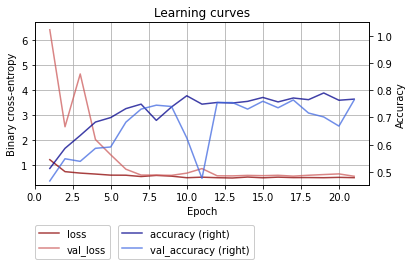

In [ ]:
# 6.
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist9.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

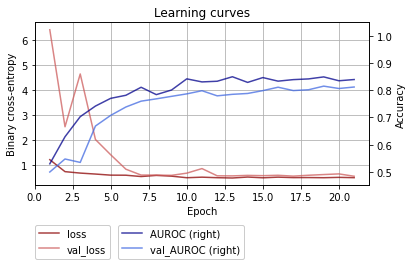

In [ ]:
# 6.
secondary_y = ["AUROC", "val_AUROC"]
ax = df_hist9.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
len(cnn9.layers)

16

## 4.10. CNN-V10.
Consider the architecture CNN-V4 with regularization and dropout.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v10
cnn10 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second (closing) block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn10.build(input_shape)
# Check network
cnn10.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_16 (RandomFlip)  (64, 128, 128, 3)        0         
                                                                 
 random_rotation_16 (RandomR  (64, 128, 128, 3)        0         
 otation)                                                        
                                                                 
 random_zoom_16 (RandomZoom)  (64, 128, 128, 3)        0         
                                                                 
 random_translation_16 (Rand  (64, 128, 128, 3)        0         
 omTranslation)                                                  
                                                                 
 random_contrast_16 (RandomC  (64, 128, 128, 3)        0         
 ontrast)                                                        
                                                     

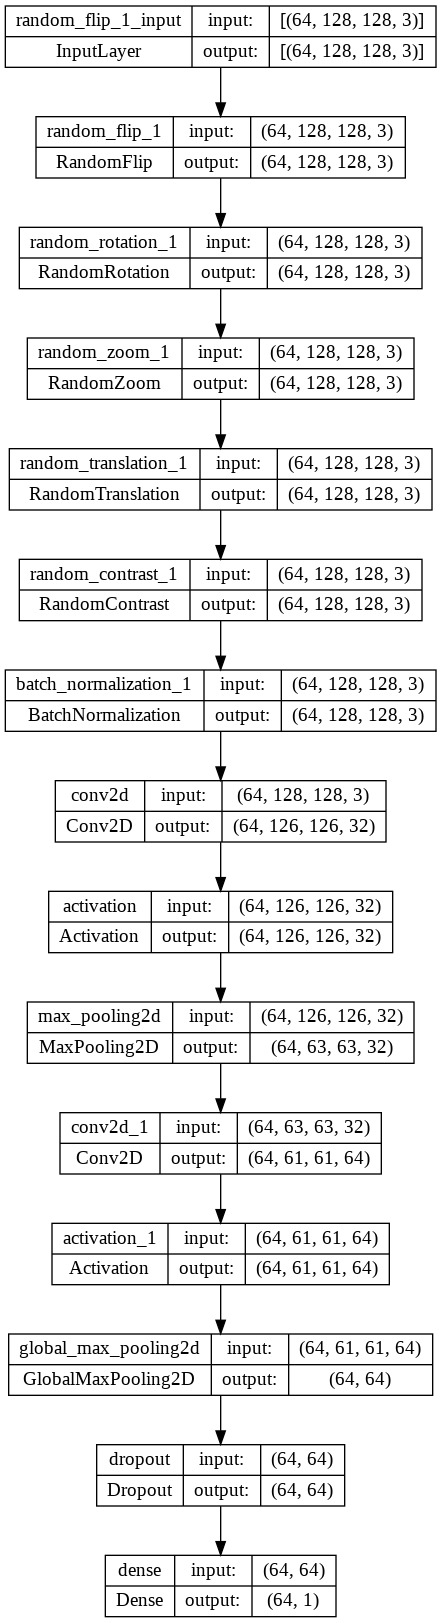

In [ ]:
tf.keras.utils.plot_model(cnn10, show_shapes=True)

The cells below:
1. compiles the model
2. setup calbacks
3. trains the model
4. evaluates the model
5. creates a ``pandas.DataFrame`` from ``history`` dictionary 
6. plots the learning curves.

In [ ]:
# 1.
learning_rate=0.01
cnn10.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])

In [ ]:
# 2.
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=4,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn10_checkpoint",
    monitor="val_accuracy",
    save_freq="epoch", # default value is 'epoch'
    save_best_only=True
)

In [ ]:
# 3.
epochs = 100
history10 = cnn10.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[early_stopping, model_checkpoint])
cnn10.save("cnn_model.h10")

Epoch 1/100


8/8 [==============================] - ETA: 0s - loss: 1.0676 - accuracy: 0.4979 - recall: 0.6520 - precision: 0.5094 - AUROC: 0.4849

8/8 [==============================] - 41s 3s/step - loss: 1.0676 - accuracy: 0.4979 - recall: 0.6520 - precision: 0.5094 - AUROC: 0.4849 - val_loss: 1.4225 - val_accuracy: 0.5337 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_AUROC: 0.5320
Epoch 2/100
8/8 [==============================] - 16s 2s/step - loss: 0.7241 - accuracy: 0.5000 - recall: 0.4560 - precision: 0.5158 - AUROC: 0.5020 - val_loss: 0.6909 - val_accuracy: 0.5337 - val_recall: 0.9691 - val_precision: 0.5000 - val_AUROC: 0.7176
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.6893 - recall: 0.7680 - precision: 0.6737 - AUROC: 0.7335

8/8 [==============================] - 24s 3s/step - loss: 0.6576 - accuracy: 0.6893 - recall: 0.7680 - precision: 0.6737 - AUROC: 0.7335 - val_loss: 0.5803 - val_accuracy: 0.7115 - val_recall: 0.5052 - val_precision: 0.8033 - val_AUROC: 0.7769
Epoch 4/100
8/8 [==============================] - 17s 2s/step - loss: 0.5779 - accuracy: 0.7346 - recall: 0.7280 - precision: 0.7490 - AUROC: 0.7922 - val_loss: 0.7053 - val_accuracy: 0.6875 - val_recall: 0.4330 - val_precision: 0.8077 - val_AUROC: 0.7536
Epoch 5/100
8/8 [==============================] - ETA: 0s - loss: 0.5448 - accuracy: 0.7449 - recall: 0.6840 - precision: 0.7917 - AUROC: 0.7972

8/8 [==============================] - 30s 4s/step - loss: 0.5448 - accuracy: 0.7449 - recall: 0.6840 - precision: 0.7917 - AUROC: 0.7972 - val_loss: 0.7016 - val_accuracy: 0.7404 - val_recall: 0.7423 - val_precision: 0.7129 - val_AUROC: 0.7796
Epoch 6/100
8/8 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.7634 - recall: 0.6960 - precision: 0.8169 - AUROC: 0.8085

8/8 [==============================] - 24s 3s/step - loss: 0.5465 - accuracy: 0.7634 - recall: 0.6960 - precision: 0.8169 - AUROC: 0.8085 - val_loss: 0.6280 - val_accuracy: 0.7500 - val_recall: 0.6392 - val_precision: 0.7848 - val_AUROC: 0.7838
Epoch 7/100
8/8 [==============================] - ETA: 0s - loss: 0.5292 - accuracy: 0.7634 - recall: 0.6720 - precision: 0.8358 - AUROC: 0.8004

8/8 [==============================] - 26s 3s/step - loss: 0.5292 - accuracy: 0.7634 - recall: 0.6720 - precision: 0.8358 - AUROC: 0.8004 - val_loss: 0.5998 - val_accuracy: 0.7596 - val_recall: 0.7010 - val_precision: 0.7640 - val_AUROC: 0.7938
Epoch 8/100
8/8 [==============================] - 20s 2s/step - loss: 0.5207 - accuracy: 0.7737 - recall: 0.6840 - precision: 0.8465 - AUROC: 0.8329 - val_loss: 0.5982 - val_accuracy: 0.7548 - val_recall: 0.5979 - val_precision: 0.8286 - val_AUROC: 0.7859
Epoch 9/100
8/8 [==============================] - 17s 2s/step - loss: 0.5196 - accuracy: 0.7387 - recall: 0.6800 - precision: 0.7834 - AUROC: 0.8142 - val_loss: 0.6554 - val_accuracy: 0.7404 - val_recall: 0.5464 - val_precision: 0.8413 - val_AUROC: 0.7764
Epoch 10/100
8/8 [==============================] - 18s 2s/step - loss: 0.5186 - accuracy: 0.7366 - recall: 0.6200 - precision: 0.8245 - AUROC: 0.8138 - val_loss: 0.5975 - val_accuracy: 0.7548 - val_recall: 0.6907 - val_precision: 0.7614 - v

In [ ]:
# 4.
score, acc, rec, prec, auc = cnn10.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn10.evaluate(ds_val, verbose=0)

print("Val loss score: %0.3f" % (score))
print("Val accuracy: %0.3f" % (acc))
print("Val recall: %0.3f" % (rec))
print("Val precision: %0.3f" % (prec))
print("Val AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn10.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.504
Training accuracy: 0.780
Training recall: 0.736
Training precision: 0.818
Training AUROC: 0.852
Val loss score: 0.600
Val accuracy: 0.760
Val recall: 0.701
Val precision: 0.764
Val AUROC: 0.794
Test loss score: 0.620
Test accuracy: 0.750
Test recall: 0.680
Test precision: 0.791
Test AUROC: 0.770


In [ ]:
# 5. 
df_hist10 = pd.DataFrame.from_dict(history10.history)
df_hist10["Epoch"] = np.arange(1, len(df_hist10) + 1, 1)

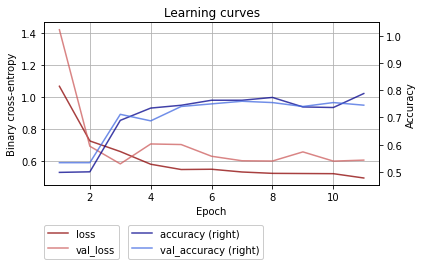

In [ ]:
# 6.
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist10.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

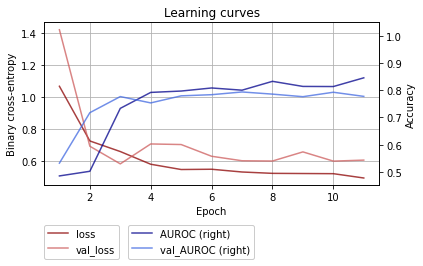

In [ ]:
# 6.
secondary_y = ["AUROC", "val_AUROC"]
ax = df_hist10.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
len(cnn10.layers)

14

## 4.11. CNN-V11.
Consider the architecture CNN-V6 with regularization and dropout.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v11
cnn11 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: third (closing) block
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn11.build(input_shape)
# Check network
cnn11.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (64, 128, 128, 3)         0         
                                                                 
 random_rotation_2 (RandomRo  (64, 128, 128, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (64, 128, 128, 3)         0         
                                                                 
 random_translation_2 (Rando  (64, 128, 128, 3)        0         
 mTranslation)                                                   
                                                                 
 random_contrast_2 (RandomCo  (64, 128, 128, 3)        0         
 ntrast)                                                         
                                                      

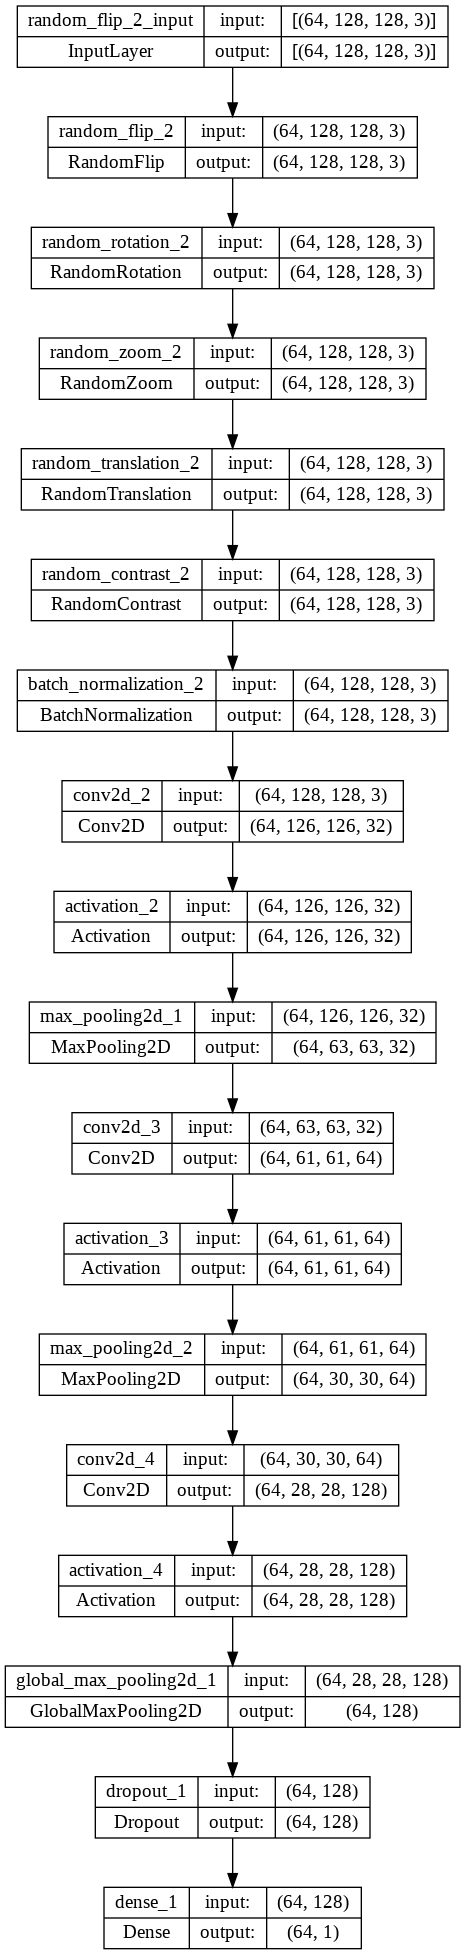

In [ ]:
tf.keras.utils.plot_model(cnn11, show_shapes=True)

The cells below:
1. compiles the model
2. setup calbacks
3. trains the model
4. evaluates the model
5. creates a ``pandas.DataFrame`` from ``history`` dictionary 
6. plots the learning curves.

In [ ]:
# 1.
learning_rate=0.01
cnn11.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])

In [ ]:
# 2.
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=4,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn11_checkpoint",
    monitor="val_accuracy",
    save_freq="epoch", # default value is 'epoch'
    save_best_only=True
)

In [ ]:
# 3.
epochs = 100
history11 = cnn11.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[early_stopping, model_checkpoint])
cnn11.save("cnn_model.h11")

Epoch 1/100


8/8 [==============================] - ETA: 0s - loss: 1.0807 - accuracy: 0.5082 - recall: 0.8320 - precision: 0.5136 - AUROC: 0.6232

8/8 [==============================] - 47s 4s/step - loss: 1.0807 - accuracy: 0.5082 - recall: 0.8320 - precision: 0.5136 - AUROC: 0.6232 - val_loss: 0.6715 - val_accuracy: 0.4760 - val_recall: 0.9794 - val_precision: 0.4703 - val_AUROC: 0.6775
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.5428 - accuracy: 0.7305 - recall: 0.7880 - precision: 0.7164 - AUROC: 0.8237

8/8 [==============================] - 27s 3s/step - loss: 0.5428 - accuracy: 0.7305 - recall: 0.7880 - precision: 0.7164 - AUROC: 0.8237 - val_loss: 2.0262 - val_accuracy: 0.5769 - val_recall: 0.0928 - val_precision: 1.0000 - val_AUROC: 0.5421
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.6059 - accuracy: 0.7078 - recall: 0.5720 - precision: 0.8034 - AUROC: 0.7546

8/8 [==============================] - 29s 4s/step - loss: 0.6059 - accuracy: 0.7078 - recall: 0.5720 - precision: 0.8034 - AUROC: 0.7546 - val_loss: 0.7229 - val_accuracy: 0.6731 - val_recall: 0.3505 - val_precision: 0.8718 - val_AUROC: 0.6610
Epoch 4/100
8/8 [==============================] - 19s 2s/step - loss: 0.6662 - accuracy: 0.6523 - recall: 0.4480 - precision: 0.7832 - AUROC: 0.6807 - val_loss: 0.6690 - val_accuracy: 0.6250 - val_recall: 0.2165 - val_precision: 0.9130 - val_AUROC: 0.6401
Epoch 5/100
8/8 [==============================] - 22s 3s/step - loss: 0.6650 - accuracy: 0.6296 - recall: 0.3280 - precision: 0.8723 - AUROC: 0.6476 - val_loss: 0.6584 - val_accuracy: 0.6442 - val_recall: 0.6598 - val_precision: 0.6095 - val_AUROC: 0.7461
Epoch 6/100
8/8 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.7058 - recall: 0.4720 - precision: 0.9147 - AUROC: 0.7316

8/8 [==============================] - 27s 3s/step - loss: 0.6223 - accuracy: 0.7058 - recall: 0.4720 - precision: 0.9147 - AUROC: 0.7316 - val_loss: 0.6549 - val_accuracy: 0.7356 - val_recall: 0.5876 - val_precision: 0.7917 - val_AUROC: 0.7673
Epoch 7/100
8/8 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.7469 - recall: 0.5680 - precision: 0.9045 - AUROC: 0.7702

8/8 [==============================] - 26s 3s/step - loss: 0.5940 - accuracy: 0.7469 - recall: 0.5680 - precision: 0.9045 - AUROC: 0.7702 - val_loss: 0.6220 - val_accuracy: 0.7404 - val_recall: 0.6392 - val_precision: 0.7654 - val_AUROC: 0.7836
Epoch 8/100
8/8 [==============================] - 18s 2s/step - loss: 0.5722 - accuracy: 0.7469 - recall: 0.6320 - precision: 0.8360 - AUROC: 0.8064 - val_loss: 0.6114 - val_accuracy: 0.6923 - val_recall: 0.8041 - val_precision: 0.6341 - val_AUROC: 0.8022
Epoch 9/100
8/8 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.7695 - recall: 0.7600 - precision: 0.7851 - AUROC: 0.8333

8/8 [==============================] - 28s 3s/step - loss: 0.5474 - accuracy: 0.7695 - recall: 0.7600 - precision: 0.7851 - AUROC: 0.8333 - val_loss: 0.6054 - val_accuracy: 0.7452 - val_recall: 0.7423 - val_precision: 0.7200 - val_AUROC: 0.7990
Epoch 10/100
8/8 [==============================] - ETA: 0s - loss: 0.5448 - accuracy: 0.7757 - recall: 0.7360 - precision: 0.8106 - AUROC: 0.8238

8/8 [==============================] - 27s 3s/step - loss: 0.5448 - accuracy: 0.7757 - recall: 0.7360 - precision: 0.8106 - AUROC: 0.8238 - val_loss: 0.5913 - val_accuracy: 0.7500 - val_recall: 0.6598 - val_precision: 0.7711 - val_AUROC: 0.7773
Epoch 11/100
8/8 [==============================] - 18s 2s/step - loss: 0.5251 - accuracy: 0.7819 - recall: 0.6760 - precision: 0.8711 - AUROC: 0.8338 - val_loss: 0.5748 - val_accuracy: 0.7308 - val_recall: 0.5979 - val_precision: 0.7733 - val_AUROC: 0.7712
Epoch 12/100
8/8 [==============================] - 19s 2s/step - loss: 0.5056 - accuracy: 0.7798 - recall: 0.6840 - precision: 0.8593 - AUROC: 0.8157 - val_loss: 0.6120 - val_accuracy: 0.7452 - val_recall: 0.6082 - val_precision: 0.7973 - val_AUROC: 0.7846
Epoch 13/100
8/8 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.7716 - recall: 0.6320 - precision: 0.8927 - AUROC: 0.8124

8/8 [==============================] - 28s 4s/step - loss: 0.5310 - accuracy: 0.7716 - recall: 0.6320 - precision: 0.8927 - AUROC: 0.8124 - val_loss: 0.5866 - val_accuracy: 0.7596 - val_recall: 0.6598 - val_precision: 0.7901 - val_AUROC: 0.7900
Epoch 14/100
8/8 [==============================] - 19s 2s/step - loss: 0.5198 - accuracy: 0.7901 - recall: 0.6840 - precision: 0.8814 - AUROC: 0.8311 - val_loss: 0.5502 - val_accuracy: 0.7548 - val_recall: 0.6289 - val_precision: 0.8026 - val_AUROC: 0.7985
Epoch 15/100
8/8 [==============================] - 19s 2s/step - loss: 0.5047 - accuracy: 0.7881 - recall: 0.7080 - precision: 0.8551 - AUROC: 0.8444 - val_loss: 0.5784 - val_accuracy: 0.7452 - val_recall: 0.7216 - val_precision: 0.7292 - val_AUROC: 0.7988
Epoch 16/100
8/8 [==============================] - 19s 2s/step - loss: 0.5029 - accuracy: 0.7901 - recall: 0.6800 - precision: 0.8854 - AUROC: 0.8258 - val_loss: 0.5572 - val_accuracy: 0.7548 - val_recall: 0.6804 - val_precision: 0.7674 -

In [ ]:
# 4.
score, acc, rec, prec, auc = cnn11.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn11.evaluate(ds_val, verbose=0)

print("Val loss score: %0.3f" % (score))
print("Val accuracy: %0.3f" % (acc))
print("Val recall: %0.3f" % (rec))
print("Val precision: %0.3f" % (prec))
print("Val AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn11.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.502
Training accuracy: 0.784
Training recall: 0.712
Training precision: 0.844
Training AUROC: 0.842
Val loss score: 0.587
Val accuracy: 0.760
Val recall: 0.660
Val precision: 0.790
Val AUROC: 0.790
Test loss score: 0.644
Test accuracy: 0.730
Test recall: 0.610
Test precision: 0.803
Test AUROC: 0.757


In [ ]:
# 5. 
df_hist11 = pd.DataFrame.from_dict(history11.history)
df_hist11["Epoch"] = np.arange(1, len(df_hist11) + 1, 1)

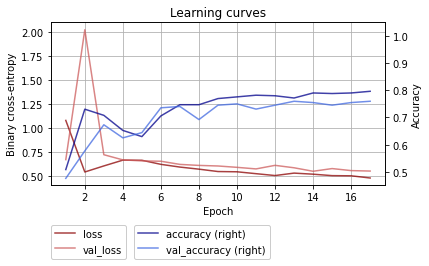

In [ ]:
# 6.
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist11.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

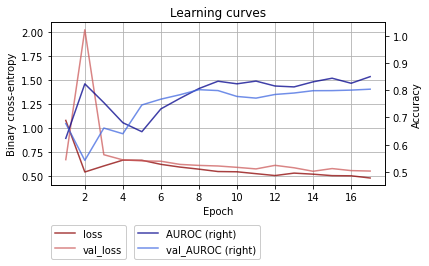

In [ ]:
# 6.
secondary_y = ["AUROC", "val_AUROC"]
ax = df_hist11.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
len(cnn11.layers)

17

## 4.12. CNN-V12.
Consider the architecture CNN-V6 with one layer with regularization and dropout.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v12
cnn12 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: third (closing) block
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn12.build(input_shape)
# Check network
cnn12.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_5 (RandomFlip)  (64, 128, 128, 3)         0         
                                                                 
 random_rotation_5 (RandomRo  (64, 128, 128, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_5 (RandomZoom)  (64, 128, 128, 3)         0         
                                                                 
 random_translation_5 (Rando  (64, 128, 128, 3)        0         
 mTranslation)                                                   
                                                                 
 random_contrast_5 (RandomCo  (64, 128, 128, 3)        0         
 ntrast)                                                         
                                                      

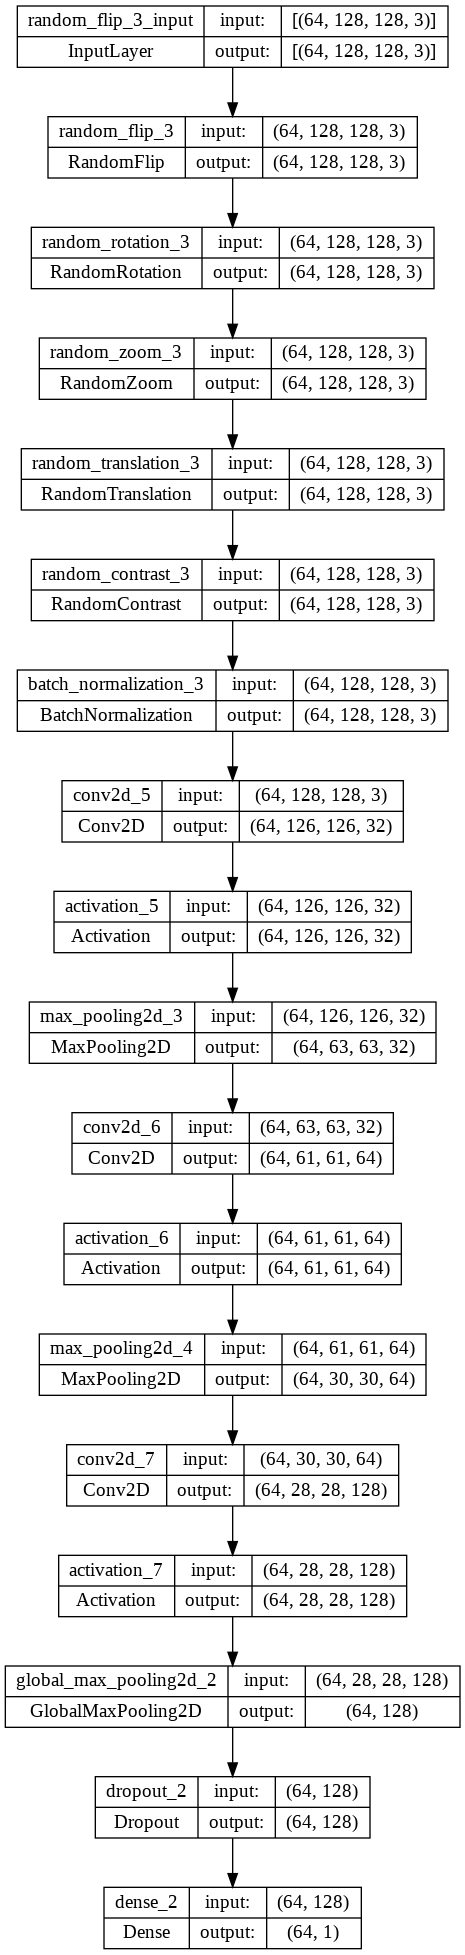

In [ ]:
tf.keras.utils.plot_model(cnn12, show_shapes=True)

The cells below:
1. compiles the model
2. setup calbacks
3. trains the model
4. evaluates the model
5. creates a ``pandas.DataFrame`` from ``history`` dictionary 
6. plots the learning curves.

In [ ]:
# 1.
cnn12.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])

In [ ]:
# 2.
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="cnn12_checkpoint",
    monitor="val_accuracy",
    save_freq="epoch", # default value is 'epoch'
    save_best_only=True
)

In [ ]:
# 3.
epochs = 100
history12 = cnn12.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[early_stopping, model_checkpoint])
cnn12.save("cnn_model.h12")

Epoch 1/100


8/8 [==============================] - ETA: 0s - loss: 1.1149 - accuracy: 0.5144 - recall: 0.1920 - precision: 0.5854 - AUROC: 0.5037

8/8 [==============================] - 42s 4s/step - loss: 1.1149 - accuracy: 0.5144 - recall: 0.1920 - precision: 0.5854 - AUROC: 0.5037 - val_loss: 0.6940 - val_accuracy: 0.4712 - val_recall: 0.1753 - val_precision: 0.3617 - val_AUROC: 0.4374
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.5144 - recall: 0.7760 - precision: 0.5187 - AUROC: 0.5106

8/8 [==============================] - 26s 3s/step - loss: 0.6948 - accuracy: 0.5144 - recall: 0.7760 - precision: 0.5187 - AUROC: 0.5106 - val_loss: 0.7064 - val_accuracy: 0.5288 - val_recall: 0.0412 - val_precision: 0.4444 - val_AUROC: 0.4987
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.5329 - recall: 0.8520 - precision: 0.5285 - AUROC: 0.5759

8/8 [==============================] - 27s 3s/step - loss: 0.6868 - accuracy: 0.5329 - recall: 0.8520 - precision: 0.5285 - AUROC: 0.5759 - val_loss: 0.9757 - val_accuracy: 0.5337 - val_recall: 0.0103 - val_precision: 0.5000 - val_AUROC: 0.5133
Epoch 4/100
8/8 [==============================] - 20s 2s/step - loss: 0.6962 - accuracy: 0.5226 - recall: 0.7720 - precision: 0.5245 - AUROC: 0.5386 - val_loss: 0.7156 - val_accuracy: 0.5288 - val_recall: 0.0722 - val_precision: 0.4667 - val_AUROC: 0.5257
Epoch 5/100
8/8 [==============================] - 19s 2s/step - loss: 0.6830 - accuracy: 0.5556 - recall: 0.6920 - precision: 0.5545 - AUROC: 0.5708 - val_loss: 0.6863 - val_accuracy: 0.5144 - val_recall: 0.2680 - val_precision: 0.4643 - val_AUROC: 0.5506
Epoch 6/100
8/8 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.6111 - recall: 0.8720 - precision: 0.5813 - AUROC: 0.6699

8/8 [==============================] - 26s 3s/step - loss: 0.6563 - accuracy: 0.6111 - recall: 0.8720 - precision: 0.5813 - AUROC: 0.6699 - val_loss: 1.2611 - val_accuracy: 0.5385 - val_recall: 0.0103 - val_precision: 1.0000 - val_AUROC: 0.5456
Epoch 7/100
8/8 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.6049 - recall: 0.6800 - precision: 0.6028 - AUROC: 0.6371

8/8 [==============================] - 26s 3s/step - loss: 0.6614 - accuracy: 0.6049 - recall: 0.6800 - precision: 0.6028 - AUROC: 0.6371 - val_loss: 0.7870 - val_accuracy: 0.5769 - val_recall: 0.1237 - val_precision: 0.8000 - val_AUROC: 0.6005
Epoch 8/100
8/8 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.7058 - recall: 0.6160 - precision: 0.7662 - AUROC: 0.7509

8/8 [==============================] - 28s 4s/step - loss: 0.5786 - accuracy: 0.7058 - recall: 0.6160 - precision: 0.7662 - AUROC: 0.7509 - val_loss: 0.6173 - val_accuracy: 0.7260 - val_recall: 0.5773 - val_precision: 0.7778 - val_AUROC: 0.7553
Epoch 9/100
8/8 [==============================] - 19s 2s/step - loss: 0.5255 - accuracy: 0.7490 - recall: 0.7000 - precision: 0.7883 - AUROC: 0.8054 - val_loss: 0.6136 - val_accuracy: 0.6875 - val_recall: 0.4124 - val_precision: 0.8333 - val_AUROC: 0.7271
Epoch 10/100
8/8 [==============================] - 21s 2s/step - loss: 0.5056 - accuracy: 0.7716 - recall: 0.6920 - precision: 0.8357 - AUROC: 0.8170 - val_loss: 0.6264 - val_accuracy: 0.7163 - val_recall: 0.5979 - val_precision: 0.7436 - val_AUROC: 0.7349
Epoch 11/100
8/8 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.7407 - recall: 0.6640 - precision: 0.7981 - AUROC: 0.7799

8/8 [==============================] - 27s 4s/step - loss: 0.5573 - accuracy: 0.7407 - recall: 0.6640 - precision: 0.7981 - AUROC: 0.7799 - val_loss: 0.6133 - val_accuracy: 0.7548 - val_recall: 0.7423 - val_precision: 0.7347 - val_AUROC: 0.7983
Epoch 12/100
8/8 [==============================] - 18s 2s/step - loss: 0.5457 - accuracy: 0.7469 - recall: 0.6040 - precision: 0.8629 - AUROC: 0.7941 - val_loss: 0.5494 - val_accuracy: 0.7404 - val_recall: 0.5670 - val_precision: 0.8209 - val_AUROC: 0.7645
Epoch 13/100
8/8 [==============================] - 19s 2s/step - loss: 0.5003 - accuracy: 0.7634 - recall: 0.7200 - precision: 0.8000 - AUROC: 0.8313 - val_loss: 0.5567 - val_accuracy: 0.7548 - val_recall: 0.5979 - val_precision: 0.8286 - val_AUROC: 0.7625
Epoch 14/100
8/8 [==============================] - 21s 2s/step - loss: 0.4880 - accuracy: 0.7798 - recall: 0.7200 - precision: 0.8295 - AUROC: 0.8382 - val_loss: 0.5710 - val_accuracy: 0.7452 - val_recall: 0.5773 - val_precision: 0.8235 -

In [ ]:
# 4.
score, acc, rec, prec, auc = cnn12.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn12.evaluate(ds_val, verbose=0)

print("Val loss score: %0.3f" % (score))
print("Val accuracy: %0.3f" % (acc))
print("Val recall: %0.3f" % (rec))
print("Val precision: %0.3f" % (prec))
print("Val AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn12.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.511
Training accuracy: 0.767
Training recall: 0.756
Training precision: 0.784
Training AUROC: 0.836
Val loss score: 0.613
Val accuracy: 0.755
Val recall: 0.742
Val precision: 0.735
Val AUROC: 0.798
Test loss score: 0.624
Test accuracy: 0.735
Test recall: 0.680
Test precision: 0.764
Test AUROC: 0.785


In [ ]:
# 5. 
df_hist12 = pd.DataFrame.from_dict(history12.history)
df_hist12["Epoch"] = np.arange(1, len(df_hist12) + 1, 1)

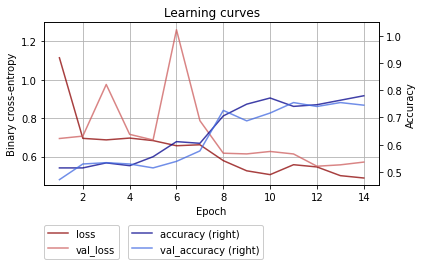

In [ ]:
# 6.
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist12.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

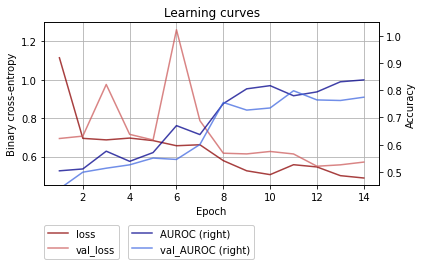

In [ ]:
# 6.
secondary_y = ["AUROC", "val_AUROC"]
ax = df_hist12.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
len(cnn12.layers)

17

## 5. Re-train on the training set and assess on the test set. 

Generate a new object of type ``tf.data.Dataset`` for training data. Note that ``validation_split`` and ``subset`` arguments are not being provided.

In [ ]:
ds_train = image_dataset_from_directory(path + main_folder + training_folder, 
                                        image_size=image_size,
                                        crop_to_aspect_ratio=crop_to_aspect_ratio,
                                        color_mode=color_mode,
                                        batch_size=batch_size,
                                        label_mode=label_mode,
                                        shuffle=shuffle,
                                        seed=seed)

Found 694 files belonging to 2 classes.


## 5.1. CNN-V1.

Re-creates the model.

In [ ]:
input_shape = batch_x_train.shape
# Architecture v1
cnn1 = Sequential([# Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn1.build(input_shape)

Fits the model on the training set.

In [ ]:
# 1.
cnn1.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 25
history1 = cnn1.fit(ds_train, epochs=epochs, verbose=0)

Evaluates the model.

In [ ]:
score, acc, rec, prec, auc = cnn1.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn1.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.048
Training accuracy: 0.996
Training recall: 0.994
Training precision: 0.997
Training AUROC: 1.000
Test loss score: 1.169
Test accuracy: 0.715
Test recall: 0.710
Test precision: 0.717
Test AUROC: 0.771


Obtains predictions and targets on the test set.

In [ ]:
y_pred_test, y_test = [], []
for batch in ds_test:    
    y_pred_test.append(cnn1.predict(batch[0]))
    y_test.append(batch[1])

1/1 [==============================] - 0s 115ms/step


Creates and plots a confusion matrix.

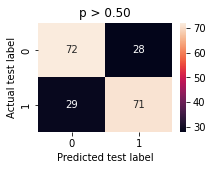

In [ ]:
# Define visualization function for CM
def plot_cm(y_true, y_pred, threshold=0.5, split="test"):
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_true, y_pred > threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('p > {:.2f}'.format(threshold))
    plt.ylabel(f'Actual {split} label')
    plt.xlabel(f'Predicted {split} label')
    
plot_cm(tf.concat(y_test, 0), tf.concat(y_pred_test, 0))

## 5.2. CNN-V2.

Re-creates the model

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v2
cnn2 = Sequential([# The rescaling layer 
                   layers.Rescaling(1./255),                           
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn2.build(input_shape)

Fits the model on the training set.

In [ ]:
# 1.
cnn2.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 25
history2 = cnn2.fit(ds_train, epochs=epochs, verbose=0)

Evaluates the model.

In [ ]:
score, acc, rec, prec, auc = cnn2.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn2.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.417
Training accuracy: 0.816
Training recall: 0.726
Training precision: 0.884
Training AUROC: 0.900
Test loss score: 0.510
Test accuracy: 0.765
Test recall: 0.650
Test precision: 0.844
Test AUROC: 0.830


Obtains predictions.

In [ ]:
y_pred_test, y_test = [], []
for batch in ds_test:    
    y_pred_test.append(cnn2.predict(batch[0]))
    y_test.append(batch[1])

1/1 [==============================] - 0s 121ms/step


Creates and plots confusion matrix.

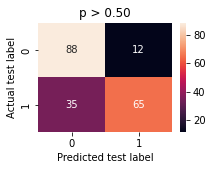

In [ ]:
# Define visualization function for CM
def plot_cm(y_true, y_pred, threshold=0.5, split="test"):
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_true, y_pred > threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('p > {:.2f}'.format(threshold))
    plt.ylabel(f'Actual {split} label')
    plt.xlabel(f'Predicted {split} label')
    
plot_cm(tf.concat(y_test, 0), tf.concat(y_pred_test, 0))

## 5.3. CNN-V3.

Re-creates the model.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v3
cnn3 = Sequential([# The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn3.build(input_shape)

Fits the model on the training set.

In [ ]:
# 1.
cnn3.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 25
history3 = cnn3.fit(ds_train, epochs=epochs, verbose=0)

Evaluates the model.

In [ ]:
score, acc, rec, prec, auc = cnn3.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn3.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.279
Training accuracy: 0.914
Training recall: 0.922
Training precision: 0.907
Training AUROC: 0.966
Test loss score: 0.457
Test accuracy: 0.795
Test recall: 0.780
Test precision: 0.804
Test AUROC: 0.870


Obtains predictions.

In [ ]:
y_pred_test, y_test = [], []
for batch in ds_test:    
    y_pred_test.append(cnn3.predict(batch[0]))
    y_test.append(batch[1])

1/1 [==============================] - 0s 128ms/step


Creates and plots confusion matrix.

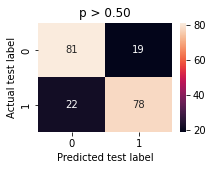

In [ ]:
# Define visualization function for CM
def plot_cm(y_true, y_pred, threshold=0.5, split="test"):
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_true, y_pred > threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('p > {:.2f}'.format(threshold))
    plt.ylabel(f'Actual {split} label')
    plt.xlabel(f'Predicted {split} label')
    
plot_cm(tf.concat(y_test, 0), tf.concat(y_pred_test, 0))

## 5.4. CNN-V4.

Re-creates the model.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v4
cnn4 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn4.build(input_shape)

Fits the model on the training set.

In [ ]:
# 1.
cnn4.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 25
history4 = cnn4.fit(ds_train, epochs=epochs, verbose=0)

Evaluates the model.

In [ ]:
score, acc, rec, prec, auc = cnn4.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn4.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.419
Training accuracy: 0.818
Training recall: 0.764
Training precision: 0.858
Training AUROC: 0.888
Test loss score: 0.494
Test accuracy: 0.745
Test recall: 0.670
Test precision: 0.788
Test AUROC: 0.848


Obtains predictions.

In [ ]:
y_pred_test, y_test = [], []
for batch in ds_test:    
    y_pred_test.append(cnn4.predict(batch[0]))
    y_test.append(batch[1])

1/1 [==============================] - 0s 131ms/step


Creates and plots confusion matrix.

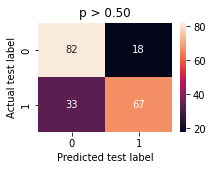

In [ ]:
# Define visualization function for CM
def plot_cm(y_true, y_pred, threshold=0.5, split="test"):
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_true, y_pred > threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('p > {:.2f}'.format(threshold))
    plt.ylabel(f'Actual {split} label')
    plt.xlabel(f'Predicted {split} label')
    
plot_cm(tf.concat(y_test, 0), tf.concat(y_pred_test, 0))

## 5.5. CNN-V5.

Re-creates the model.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v5
cnn5 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn5.build(input_shape)

Fits the model on the training set.

In [ ]:
# 1.
cnn5.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 25
history5 = cnn5.fit(ds_train, epochs=epochs, verbose=0)

Evaluates the model.

In [ ]:
score, acc, rec, prec, auc = cnn5.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn5.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.472
Training accuracy: 0.795
Training recall: 0.637
Training precision: 0.932
Training AUROC: 0.892
Test loss score: 0.548
Test accuracy: 0.750
Test recall: 0.570
Test precision: 0.891
Test AUROC: 0.792


Obtains predictions.

In [ ]:
y_pred_test, y_test = [], []
for batch in ds_test:    
    y_pred_test.append(cnn5.predict(batch[0]))
    y_test.append(batch[1])

1/1 [==============================] - 0s 163ms/step


Creates and plots confusion matrix.

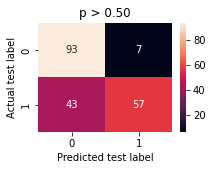

In [ ]:
# Define visualization function for CM
def plot_cm(y_true, y_pred, threshold=0.5, split="test"):
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_true, y_pred > threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('p > {:.2f}'.format(threshold))
    plt.ylabel(f'Actual {split} label')
    plt.xlabel(f'Predicted {split} label')
    
plot_cm(tf.concat(y_test, 0), tf.concat(y_pred_test, 0))

## 5.6. CNN-V9.

Re-creates the model.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v9
cnn9 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second (closing) block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn9.build(input_shape)

Fits the model on the training set.

In [ ]:
# 1.
cnn9.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 27
history9 = cnn9.fit(ds_train, epochs=epochs, verbose=0)

Evaluates the model.

In [ ]:
score, acc, rec, prec, auc = cnn9.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn9.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.485
Training accuracy: 0.772
Training recall: 0.617
Training precision: 0.895
Training AUROC: 0.872
Test loss score: 0.529
Test accuracy: 0.755
Test recall: 0.600
Test precision: 0.870
Test AUROC: 0.819


Obtains predictions.

In [ ]:
y_pred_test, y_test = [], []
for batch in ds_test:    
    y_pred_test.append(cnn9.predict(batch[0]))
    y_test.append(batch[1])

1/1 [==============================] - 0s 186ms/step


Creates and plots confusion matrix.

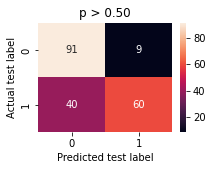

In [ ]:
# Define visualization function for CM
def plot_cm(y_true, y_pred, threshold=0.5, split="test"):
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_true, y_pred > threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('p > {:.2f}'.format(threshold))
    plt.ylabel(f'Actual {split} label')
    plt.xlabel(f'Predicted {split} label')
    
plot_cm(tf.concat(y_test, 0), tf.concat(y_pred_test, 0))

## 5.7. CNN-V10.

Re-creates the model.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v10
cnn10 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second (closing) block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn10.build(input_shape)

Fits the model on the training set.

In [ ]:
# 1.
cnn10.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 30
history10 = cnn10.fit(ds_train, epochs=epochs, verbose=0)

Evaluates the model.

In [ ]:
score, acc, rec, prec, auc = cnn10.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn10.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.450
Training accuracy: 0.808
Training recall: 0.695
Training precision: 0.899
Training AUROC: 0.879
Test loss score: 0.520
Test accuracy: 0.740
Test recall: 0.600
Test precision: 0.833
Test AUROC: 0.835


Obtains predictions.

In [ ]:
y_pred_test, y_test = [], []
for batch in ds_test:    
    y_pred_test.append(cnn10.predict(batch[0]))
    y_test.append(batch[1])

1/1 [==============================] - 0s 138ms/step


Creates and plots confusion matrix

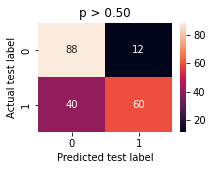

In [ ]:
# Define visualization function for CM
def plot_cm(y_true, y_pred, threshold=0.5, split="test"):
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_true, y_pred > threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('p > {:.2f}'.format(threshold))
    plt.ylabel(f'Actual {split} label')
    plt.xlabel(f'Predicted {split} label')
    
plot_cm(tf.concat(y_test, 0), tf.concat(y_pred_test, 0))

## 5.8. CNN-V6.

Re-creates the model.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v6
cnn6 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: third (closing) block
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn6.build(input_shape)

Fits the model on the training set.

In [ ]:
# 1.
learning_rate = 0.001
cnn6.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 30
history6 = cnn6.fit(ds_train, epochs=epochs, verbose=0)

Evaluates the model.

In [ ]:
score, acc, rec, prec, auc = cnn6.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn6.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.389
Training accuracy: 0.833
Training recall: 0.931
Training precision: 0.778
Training AUROC: 0.934
Test loss score: 0.548
Test accuracy: 0.775
Test recall: 0.860
Test precision: 0.735
Test AUROC: 0.869


Obtains predictions.

In [ ]:
y_pred_test, y_test = [], []
for batch in ds_test:    
    y_pred_test.append(cnn6.predict(batch[0]))
    y_test.append(batch[1])

1/1 [==============================] - 0s 164ms/step


Creates and plots confusion matrix.

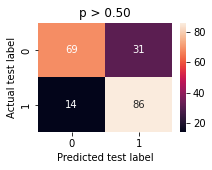

In [ ]:
# Define visualization function for CM
def plot_cm(y_true, y_pred, threshold=0.5, split="test"):
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_true, y_pred > threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('p > {:.2f}'.format(threshold))
    plt.ylabel(f'Actual {split} label')
    plt.xlabel(f'Predicted {split} label')
    
plot_cm(tf.concat(y_test, 0), tf.concat(y_pred_test, 0))

## 5.9. CNN-V7.

Re-creates the model.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v7
cnn7 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: third (closing) block
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn7.build(input_shape)

Fits the model on the training set.

In [ ]:
# 1.
cnn7.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 27
history7 = cnn7.fit(ds_train, epochs=epochs, verbose=0)

Evaluates the model.

In [ ]:
score, acc, rec, prec, auc = cnn7.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn7.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.397
Training accuracy: 0.831
Training recall: 0.697
Training precision: 0.953
Training AUROC: 0.943
Test loss score: 0.491
Test accuracy: 0.750
Test recall: 0.600
Test precision: 0.857
Test AUROC: 0.861


Obtains predictions.

In [ ]:
y_pred_test, y_test = [], []
for batch in ds_test:    
    y_pred_test.append(cnn7.predict(batch[0]))
    y_test.append(batch[1])

1/1 [==============================] - 0s 359ms/step


Creates and plots confusion matrix.

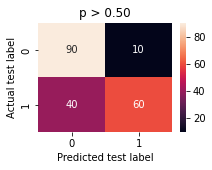

In [ ]:
# Define visualization function for CM
def plot_cm(y_true, y_pred, threshold=0.5, split="test"):
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_true, y_pred > threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('p > {:.2f}'.format(threshold))
    plt.ylabel(f'Actual {split} label')
    plt.xlabel(f'Predicted {split} label')
    
plot_cm(tf.concat(y_test, 0), tf.concat(y_pred_test, 0))

## 5.10. CNN-V8.

Re-creates the model.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v8
cnn8 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: third (closing) block
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn8.build(input_shape)

Fits the model on the training set.

In [ ]:
# 1.
cnn8.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 27
history8 = cnn8.fit(ds_train, epochs=epochs, verbose=0)

Evaluates the model.

In [ ]:
score, acc, rec, prec, auc = cnn8.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn8.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.406
Training accuracy: 0.837
Training recall: 0.795
Training precision: 0.868
Training AUROC: 0.918
Test loss score: 0.512
Test accuracy: 0.760
Test recall: 0.700
Test precision: 0.795
Test AUROC: 0.831


Obtains predictions.

In [ ]:
y_pred_test, y_test = [], []
for batch in ds_test:    
    y_pred_test.append(cnn8.predict(batch[0]))
    y_test.append(batch[1])

1/1 [==============================] - 0s 228ms/step


Creates and plots confusion matrix.

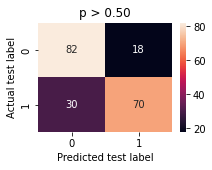

In [ ]:
# Define visualization function for CM
def plot_cm(y_true, y_pred, threshold=0.5, split="test"):
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_true, y_pred > threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('p > {:.2f}'.format(threshold))
    plt.ylabel(f'Actual {split} label')
    plt.xlabel(f'Predicted {split} label')
    
plot_cm(tf.concat(y_test, 0), tf.concat(y_pred_test, 0))

## 5.11. CNN-V11.

Re-creates the model.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v11
cnn11 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: third (closing) block
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn11.build(input_shape)

Fits the model on the training set.

In [ ]:
# 1.
cnn11.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 25
history11 = cnn11.fit(ds_train, epochs=epochs, verbose=0)

Evaluates the model.

In [ ]:
score, acc, rec, prec, auc = cnn11.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn11.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.396
Training accuracy: 0.839
Training recall: 0.896
Training precision: 0.804
Training AUROC: 0.924
Test loss score: 0.483
Test accuracy: 0.795
Test recall: 0.810
Test precision: 0.786
Test AUROC: 0.869


Obtains predictions.

In [ ]:
y_pred_test, y_test = [], []
for batch in ds_test:    
    y_pred_test.append(cnn11.predict(batch[0]))
    y_test.append(batch[1])

1/1 [==============================] - 0s 169ms/step


Creates and plots confusion matrix.

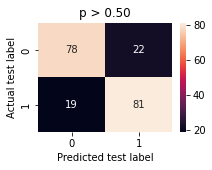

In [ ]:
# Define visualization function for CM
def plot_cm(y_true, y_pred, threshold=0.5, split="test"):
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_true, y_pred > threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('p > {:.2f}'.format(threshold))
    plt.ylabel(f'Actual {split} label')
    plt.xlabel(f'Predicted {split} label')
    
plot_cm(tf.concat(y_test, 0), tf.concat(y_pred_test, 0))

## 5.12. CNN-V12.

Re-creates the model.

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v12
cnn12 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: third (closing) block
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn12.build(input_shape)

Fits the model on the training dataset.

In [ ]:
# 1.
learning_rate = 0.001
cnn12.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 30
history12 = cnn12.fit(ds_train, epochs=epochs, verbose=0)

Evaluates the model.

In [ ]:
score, acc, rec, prec, auc = cnn12.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn12.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

Training loss score: 0.407
Training accuracy: 0.837
Training recall: 0.896
Training precision: 0.802
Training AUROC: 0.917
Test loss score: 0.507
Test accuracy: 0.795
Test recall: 0.820
Test precision: 0.781
Test AUROC: 0.876


Obtains predictions.

In [ ]:
y_pred_test, y_test = [], []
for batch in ds_test:    
    y_pred_test.append(cnn12.predict(batch[0]))
    y_test.append(batch[1])

1/1 [==============================] - 0s 150ms/step


Creates and plots confusion matrix.

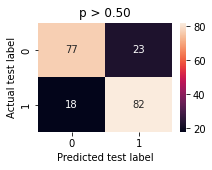

In [ ]:
# Define visualization function for CM
def plot_cm(y_true, y_pred, threshold=0.5, split="test"):
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_true, y_pred > threshold)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('p > {:.2f}'.format(threshold))
    plt.ylabel(f'Actual {split} label')
    plt.xlabel(f'Predicted {split} label')
    
plot_cm(tf.concat(y_test, 0), tf.concat(y_pred_test, 0))

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v13
cnn13 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: third (closing) block
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=64, activation="relu",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dropout(0.2),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn13.build(input_shape)

In [ ]:
# 1.
cnn13.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 27
history13 = cnn13.fit(ds_train, epochs=epochs, verbose=0)

In [ ]:
score, acc, rec, prec, auc = cnn13.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn13.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))

In [ ]:
input_shape = tuple(batch_x_train.shape)
# Architecture v14
cnn14 = Sequential([# Add data augmentation
                   layers.RandomFlip(seed=seed), 
                   layers.RandomRotation(0.1, seed=seed), 
                   layers.RandomZoom(0.1, seed=seed),
                   layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
                   layers.RandomContrast(0.1, seed=seed),
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction: first block
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L1(1e-4),
                                 bias_regularizer=regularizers.L1(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: second block
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # Feature extraction: third (closing) block
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.2),
                   # Classification
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG
cnn14.build(input_shape)

In [ ]:
# 1.
cnn14.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.Recall(name="recall"), 
                      metrics.Precision(name="precision"),
                      metrics.AUC(name='AUROC')])
# 2. 
epochs = 27
history14 = cnn14.fit(ds_train, epochs=epochs, verbose=0)

In [ ]:
score, acc, rec, prec, auc = cnn14.evaluate(ds_train, verbose=0)

print("Training loss score: %0.3f" % (score))
print("Training accuracy: %0.3f" % (acc))
print("Training recall: %0.3f" % (rec))
print("Training precision: %0.3f" % (prec))
print("Training AUROC: %0.3f" % (auc))

score, acc, rec, prec, auc = cnn14.evaluate(ds_test, verbose=0)

print("Test loss score: %0.3f" % (score))
print("Test accuracy: %0.3f" % (acc))
print("Test recall: %0.3f" % (rec))
print("Test precision: %0.3f" % (prec))
print("Test AUROC: %0.3f" % (auc))